In [2]:
# MO444-A 2s/2017 - Third assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Markdown, display
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale

def printm(msg):
    """Print in notebook using markups."""
    display(Markdown(msg))

def loadIDs():
    lines=[]
    with open('documents/ids', "r") as f:
        lines = f.read().splitlines()
    return np.asarray(lines)

def loadFeatures():
    features = pd.read_csv('documents/data.csv', sep=',', header=None)
    return features.values

def loadDocument(docID):
    data = None
    with open('documents/docs/' + docID, 'r') as docfile:
        data = docfile.read()
    return data

def computeKMeansMetrics(model, data):
    labels = model.fit_predict(data)
    cost = model.inertia_
    sil_avg = silhouette_score(data, labels)
    ch_score = calinski_harabaz_score(data, labels)
    return labels, cost, sil_avg, ch_score

In [61]:
ids = loadIDs()
print('IDs shape: {}'.format(ids.shape))

data = loadFeatures()
print('Data shape: {}'.format(data.shape))

#TEMP ... REMOVE
sel_rows = np.random.choice(data.shape[0], 2*data.shape[1], replace=False)
ids = ids[sel_rows]
data = data[sel_rows,:]
print('NEW SHAPE IDS: {}'.format(ids.shape))
print('NEW SHAPE DATA: {}'.format(data.shape))
#TEMP /REMOVE

IDs shape: (19924,)
Data shape: (19924, 2209)
NEW SHAPE IDS: (4418,)
NEW SHAPE DATA: (4418, 2209)


In [62]:
# Let's look at the 5 first instances of the IDs
print(ids[0:5])

['1b784548d517c4803f31dd0a4eaf9e3b7cc9976e'
 'c158c3cbf05b692f3e1f8842025bb85d67846715'
 '9a8c209b8bc70b2f5f019395ca0ebd6e9ebbad00'
 '97c242611d3cdf791f8a866d15523f2723667619'
 'd02e5287f917a2a460057016bb85d0dfd5a4251b']


In [63]:
# Now, let's have a look at the 5 first instances of the data (bag-of-words feature vectors)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208
0,0.0,0.0,0.0,0.0,0.055092,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029346,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037604,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069717,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019509,0.0,0.0


In [64]:
# Checking the value ranges
print('Min. value: {}'.format(np.min(data.flatten())))
print('Max. value: {}'.format(np.max(data.flatten())))

# Let's scale and normalize the data
data = scale(data)

normalizer = Normalizer()
normalizer = normalizer.fit(data)

data = normalizer.transform(data)

Min. value: 0.0
Max. value: 0.999901


In [82]:
%matplotlib inline

def printGraphsForMultipleCentroids(num_centroids, costs, sil_avgs, ch_scores):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col')

    ax1.set_title('cost')
    ax1.plot(num_centroids, costs)

    ax2.set_title('silhouettes')
    ax2.plot(num_centroids, sil_avgs)

    ax3.set_title('calinski harabaz score')
    ax3.plot(num_centroids, ch_scores)

    f.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    f.set_size_inches(15, 5)
    f.show()

def runKmeansForMultipleCentroids(data):
    models, labels, costs, sil_avgs, ch_scores = [], [], [], [], []
    num_centroids = [2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
    num_centroids = [70, 80] #TEMP ..
    for i in num_centroids:
        model = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=1)
        myLabels, cost, sil_avg, ch_score = computeKMeansMetrics(model, data)
        models.append(model)
        labels.append(myLabels)
        costs.append(cost)
        sil_avgs.append(sil_avg)
        ch_scores.append(ch_score)
        print('%d clusters: Cost %5.2f; Silhouette avg %5.5f; Calinski-Harabasz Index: %5.2f' % (i, cost, sil_avg, ch_score))
    printGraphsForMultipleCentroids(num_centroids, costs, sil_avgs, ch_scores)
    return models, labels


70 clusters: Cost 4033.43; Silhouette avg 0.01885; Calinski-Harabasz Index:  6.22
80 clusters: Cost 4013.72; Silhouette avg 0.01847; Calinski-Harabasz Index:  5.70


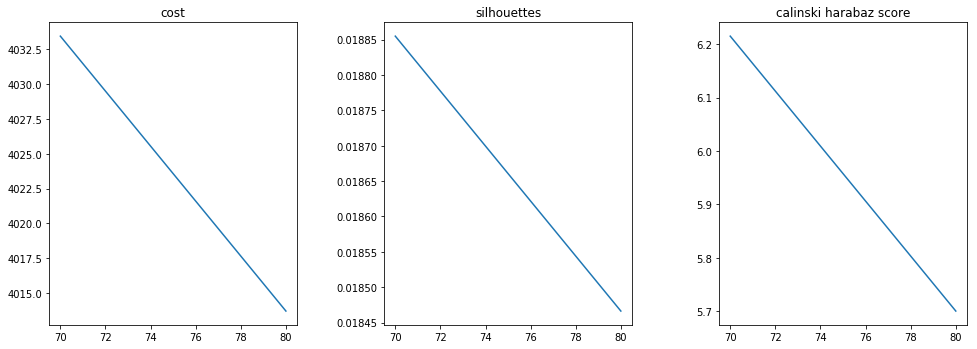

In [83]:
# Attempting Mini-Batch K means with some different number of centroids.
models, labels = runKmeansForMultipleCentroids(data)

In [85]:
##### Let's check three sample groups, their medoid documents, and two other closer documents.
import cgi

def loadEscapedDoc(doc_id):
    return cgi.escape(loadDocument(doc_id).replace('$', '').replace('*', '')).replace('\n', '<br>')

def analyze_centroids(chosen_model, chosen_model_labels, data):
    tbl = ['<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr>']
    td_style = 'style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;"'
    groups = np.random.choice(chosen_model.n_clusters, 5, replace=False)
    print('Selected groups: {}'.format(groups))
    for i in groups:
        center = chosen_model.cluster_centers_[i]
        group_points = data[chosen_model_labels == i]
        group_doc_ids = ids[chosen_model_labels == i]

        # Let's find the medoid and their closest points
        distancesMatrix = pairwise_distances(group_points, metric='euclidean')
        closest_to_medoid_indexes = np.argsort(distancesMatrix.sum(axis=0))
        medoid_index = closest_to_medoid_indexes[0]

        medoid = group_doc_ids[medoid_index]
        closest1 = group_doc_ids[closest_to_medoid_indexes[1]]
        closest2 = group_doc_ids[closest_to_medoid_indexes[2]]
        tbl.append('<td %s>**%s**<br>%s</td>'
                   '<td %s>**%s**<br>%s</td>'
                   '<td %s>**%s**<br>%s</td>' % (
            td_style, medoid, loadEscapedDoc(medoid),
            td_style, closest1, loadEscapedDoc(closest1),
            td_style, closest2, loadEscapedDoc(closest2)))

    tbl.append('</tr></table>')
    printm('</tr><tr>'.join(tbl))


In [86]:
# Chosen number of centroids
chosen_i = 14
chosen_i = 0 #TEMP ... porque diminui o numero das centroids
chosen_model = models[chosen_i]
chosen_model_labels = labels[chosen_i]
print('Chosen # of centroids: {}'.format(chosen_model.n_clusters))
print('Cost:                    %18.3f' % costs[chosen_i])
print('Silhouette avg:          %18.3f' % sil_avgs[chosen_i])
print('Calinski-Harabasz Index: %18.3f' % ch_scores[chosen_i])
analyze_centroids(chosen_model, chosen_model_labels, data)

Chosen # of centroids: 70
Cost:                             18297.541
Silhouette avg:                       0.022
Calinski-Harabasz Index:             26.047
Selected groups: [57 67 61 13 68]


<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**02e6f6e69cf282947a750182cbc85f28f20b0011**<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!agate!headwall.Stanford.EDU!rutgers!igor.rutgers.edu!geneva.rutgers.edu!christian<br>From: tbrent@ecn.purdue.edu (Timothy J Brent)<br>Newsgroups: soc.religion.christian<br>Subject: Am I going to Hell?<br>Message-ID: &lt;Apr.23.02.55.31.1993.3123@geneva.rutgers.edu&gt;<br>Date: 23 Apr 93 06:55:31 GMT<br>Sender: hedrick@geneva.rutgers.edu<br>Organization: Purdue University Engineering Computer Network<br>Lines: 12<br>Approved: christian@aramis.rutgers.edu<br><br>I have stated before that I do not consider myself an atheist, but <br>definitely do not believe in the christian god.  The recent discussion<br>about atheists and hell, combined with a post to another group (to the<br>effect of 'you will all go to hell') has me interested in the consensus <br>as to how a god might judge men.  As a catholic, I was told that a jew,<br>buddhist, etc. might go to heaven, but obviously some people do not<br>believe this.  Even more see atheists and pagans (I assume I would be <br>lumped into this category) to be hellbound.  I know you believe only<br>god can judge, and I do not ask you to, just for your opinions.<br><br>Thanks,<br>-Tim<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**40771457e0c80cce78ef42aefa0338980760cc9f**<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!dog.ee.lbl.gov!network.ucsd.edu!rutgers!igor.rutgers.edu!athos.rutgers.edu!christian<br>From: atterlep@vela.acs.oakland.edu (Cardinal Ximenez)<br>Newsgroups: soc.religion.christian<br>Subject: Atheists and Hell<br>Message-ID: &lt;Apr.19.05.14.08.1993.29279@athos.rutgers.edu&gt;<br>Date: 19 Apr 93 09:14:09 GMT<br>Sender: hedrick@athos.rutgers.edu<br>Organization: National Association for the Disorganized<br>Lines: 26<br>Approved: christian@aramis.rutgers.edu<br><br><br>  Hello,<br><br>  I have seen two common threads running through postings by atheists on the <br>newsgroup, and I think that they can be used to explain each other.  <br>Unfortunately I don't have direct quotes handy...<br><br>1) Atheists believe that when they die, they die forever.<br><br>2) A god who would condemn those who fail to believe in him to eternal death<br>   is unfair.<br><br>  I don't see what the problem is!  To Christians, Hell is, by definition, <br>eternal death--exactly what atheists are expecting when they die.  There's no<br>reason Hell has to be especially awful--to most people, eternal death is bad<br>enough.<br>  Literal interpreters of the Bible will have a problem with this view, since<br>the Bible talks about the fires of Hell and such.  Personally, I don't think<br>that people in Hell will be thrust into flame any more than I expect to Jesus<br>with a double-edged sword issuing from his mouth--I treat both these statements<br>as metaphorical.<br><br>Alan Terlep				    "...and the scorpion says, 'it's <br>Oakland University, Rochester, MI		in my nature.'"<br>atterlep@vela.acs.oakland.edu	<br>Rushing in where angels fear to tread.				--Jody<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**648b05565acd77586117aa82a5a5f734b213c424**<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!headwall.Stanford.EDU!rutgers!igor.rutgers.edu!geneva.rutgers.edu!christian<br>From: johnsd2@rpi.edu (Dan Johnson)<br>Newsgroups: soc.religion.christian<br>Subject: Re: Atheists and Hell<br>Message-ID: &lt;Apr.20.03.02.46.1993.3818@geneva.rutgers.edu&gt;<br>Date: 20 Apr 93 07:02:47 GMT<br>Sender: hedrick@geneva.rutgers.edu<br>Reply-To: johnsd2@rpi.edu<br>Organization: not Sun Microsystems<br>Lines: 38<br>Approved: christian@aramis.rutgers.edu<br><br>In article 29279@athos.rutgers.edu, atterlep@vela.acs.oakland.edu (Cardinal Ximenez) writes:<br><br>&gt;  I have seen two common threads running through postings by atheists on the <br>&gt;newsgroup, and I think that they can be used to explain each other.  <br>&gt;Unfortunately I don't have direct quotes handy...<br><br>&gt;1) Atheists believe that when they die, they die forever.<br><br>&gt;2) A god who would condemn those who fail to believe in him to eternal death<br>&gt;   is unfair.<br><br>&gt;  I don't see what the problem is!  To Christians, Hell is, by definition, <br>&gt;eternal death--exactly what atheists are expecting when they die.<br><br>This is the problem. This is not hell, this is permanent death. It is<br>indeed what atheists (generally) expect and it is neither fair nor<br>unfair, it just is. You might as well argue about whether being made<br>mostly of carbon and water is "fair".<br><br>However, the atheists who claim that Hell is unfair are talking about<br>the fire and brimstone place of endless suffering, which necessarily<br>includes eternal existance (life, I dunno, but some sort of continuation);<br>not at all the same thing.<br><br>Granted, you clearly feel that hell=death, but this is not a univeral<br>sentiment as near as I can tell.<br><br>If your idea of God "condemns" heathens to ordinary death, I have no<br>problem with that. I do have a problem with the gods that hide from humans<br>and torture the unbelievers eternally for not guessing right.<br><br>[deletia- Hell, and Literalness.]<br><br>---<br>			- Dan Johnson<br>And God said "Jeeze, this is dull"... and it WAS dull. Genesis 0:0<br><br>These opinions probably show what I know.<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**c6f002024b3068594c3f5cc8df4f5f05d61fa74e**<br>Xref: cantaloupe.srv.cs.cmu.edu alt.activism.d:7745 talk.politics.misc:178403 talk.politics.medicine:1722<br>Newsgroups: alt.activism.d,talk.politics.misc,talk.politics.medicine<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!gatech!howland.reston.ans.net!usc!sol.ctr.columbia.edu!news.columbia.edu!cunixb.cc.columbia.edu!gld<br>From: gld@cunixb.cc.columbia.edu (Gary L Dare)<br>Subject: Re: EIGHT MYTHS about National Health Insurance (Pt II)<br>Message-ID: &lt;1993Apr18.001116.19872@news.columbia.edu&gt;<br>Sender: usenet@news.columbia.edu (The Network News)<br>Nntp-Posting-Host: cunixb.cc.columbia.edu<br>Reply-To: gld@cunixb.cc.columbia.edu (Gary L Dare)<br>Organization: PhDs In The Hall<br>References: &lt;1993Apr10.064707.9714@mont.cs.missouri.edu&gt;<br>Date: Sun, 18 Apr 1993 00:11:16 GMT<br>Lines: 134<br><br>harelb@math.cornell.edu (misc.activism.progressive co-moderator) writes:<br>&gt;F&lt;O&gt;CUS/HEALTH: EIGHT MYTHS about National Health Insurance (Pt II)<br>&gt;<br>&gt;    An office visit that's 52 in Seattle is 18 in Vancouver<br>&gt;    (Canada).  That's because, among other things, they've given their<br>&gt;    government power to bargain with doctors and hospitals over fees.<br><br>The difference in the litigation environment is reflected in the fees.<br><br>Lack of defensive medicine and near-absence of malpractice is really<br>why we spend less using the most expensive approach of pure insurance<br>in Canada (along with France and Germany) without HMO's --- the NYT<br>has admitted that malpractice insurance fees are an order of magnitude<br>lower in Canada but doctors take-home pay is almost equal to American<br>doctors; also, minimal bureaucracy 'cos the system is so-o-o simple<br>(early March).<br><br>Part of the deal for using the all-insurance approach like the French<br>and Germans do (hey, why don't they criticize France and Germany?  Is<br>it because too many people take French and German in college to make<br>the accusations stick? (-;) was to preserve the doctors independance.<br>Since the provincial wings of the CMA are the ones that go to bat when<br>the fee schedule hikes are presented, the politically-bent doctors<br>were just cackling when they realized the CMA would grow in strength<br>rather than diminish, especially when unopposed unlike in socialized<br>medicine approaches like Britain's National Health Service.<br><br>&gt;"`You've got to remember, you've got a waiting list as well, but it's  <br>&gt;not as obvious. If you're poor and you don't have insurance, you don't  <br>&gt;    go to a surgeon. In the States you ration by ability to pay.'"  <br><br>For non-life threatening things, market arguments adequately cover why<br>certain procedures are in scarcer demand.  I have MD friends who can't<br>make a living as specialists back in Manitoba not due to the insurance<br>rates but because they won't get enough customers -- the CMA medical<br>monopoly's grip on doctors licencing (as in the US) aside -- so they<br>must move to larger places.  However, this does not refute debunking<br>of waiting lines for urgent AND routine care, as has been done in the<br>U.S. by Consumers Reports, health policy studies cited by Prof. Dennis<br>E. Shea on USENET, CNN, NYT, etc.<br><br>Doug Fierro has posted a NYT article from 3 weeks ago about Canada's<br>health insurance approach, on Talk.politics.medicine.  There is one<br>small error in the article: not all of our hospitals are private.<br><br>&gt;WOULDN'T NATIONAL HEALTH INSURANCE MEAN THAT AMERICANS WHO ARE NOW  <br>&gt;FULLY INSURED MIGHT HAVE TO SETTLE FOR LESS?  <br>&gt;<br>&gt;In Canada, provincial insurance covers all health costs except dental  <br>&gt;care, eyeglasses, prescription drugs, ambulance service, and private  <br>&gt;hospital rooms, -- so many Canadians do end up buying some private  <br>&gt;insurance. A policy to cover all of these things runs about #40 to 40  <br>&gt;a month.  <br><br>Of course, the one thing to note is that in the Canada/France/Germany<br>case, private insurance offloaded the basic coverage to the public<br>sector.  They realized they were keeping low-risk/high-profit extra<br>insurance for things like private/semi-private rooms (vs. ward<br>accomodation), dental, glasses, etc. for corporate or personal<br>benefits, they'll have nothing to do with you if you want to be<br>covered for basic care.<br><br>At that point, they wouldn't even consider a "voucher" approach<br>to broker the universal coverage and sell policies to make up<br>the difference in the federal guidelines and market stuff.<br><br>&gt;  <br>&gt;<br>&gt;WOULDN'T FREE CARE ENCOURAGE PEOPLE TO RUN TO THE DOCTOR FOR EVERY  <br>&gt;ACHE AND PAIN?  <br>&gt;<br>&gt;People who get free treatment do go to the doctor and hospital about  <br>&gt;a third more often than those who have to pay a share of their medical  <br>&gt;bills.  <br>&gt;<br>&gt;Still, Canadians -- who pay nothing at the doctor's -- have a lower  <br>&gt;per-person health bill than we do.<br><br>It is "free" in that there are no deductibles nor copayments (two<br>things which I advocate to make the Canadian insurance look more like<br>real health insurance -- which actually it is).  I know that when<br>working in Alberta, Ontario and Quebec, I was aware that I was paying<br>for health insurance - e.g., in Toronto, OHIP fees were listed on my<br>pay stub; Manitoba did not collect at paycheque time, but only<br>annually at income tax time (built into the tax rate).  Only fiscal<br>naifs will proclaim that it's free, along with the Canadian Left for<br>that is part of their brainwashing agenda.<br><br>The French do have copayments, though.  France Magazine's Summer <br>1992 edition has a fantastic presentation of their basic insurance<br>coverage, including a sample chart of copayment percentages.  For <br>1-30 days, you're covered for 80% of the public hospital rate, 100%<br>afterward.  With extra private insurance, you can get into a private<br>hospital and be covered for any differences beyond the public hospital<br>rate.  The public insurance covers 100% beyond 30 days, or the same<br>cash amount for a private hospital and the difference is paid<br>out-of-pocket or according to your supplementary private insurance.<br>Over 2/3rds of French have some form of extra private insurance.  So,<br>the other 30% of health costs in Europe are out of private funds, not<br>gleaned from other taxes.  The GDP figures are combined public and<br>private expenditures for total outlay using the same methods that<br>yield the 13-14% figure for the U.S.<br><br>&gt;ISN'T THE PRIVATE HEALTH INSURANCE INDUSTRY JUST TOO BIG  <br>&gt;AND POWERFUL TO KILL?  <br>&gt;<br>&gt;Dismantling the health segment of our insurance industry would be  <br>&gt;"politically thorny," in the quiet words of one advocate for a  <br>&gt;national plan. Some 1,200 firms now sell more than 192 billion in  <br>&gt;health insurance. They'd put up a hard fight. Not only has the industry  <br>&gt;grown eightfold since Canada shut down its own health insurers, but <br>&gt;our government leaves politicians more open to lobbyists than does  <br>&gt;Canada's parliamentary system.<br><br>Health insurance does exist in Canada and in Western Europe, its<br>just that it doesn't cover basic care.  You can opt out in Canada<br>and Germany, but you'll have to go uninsured as a result because<br>there are too few other people that do so --- i.e., no market.<br><br>When private insurance realized how much money they'd make without the<br>risks involved in basic insurance (e.g., neurosurgery) versus deluxe<br>amenities (e.g., having to call Granada TV to replace a rental set on<br>the fritz in someone's private hospital room), they started to pat<br>themselves on the back for their social responsibility.  In Quebec<br>last spring, a consortium of private insurers publicly warned against<br>any thoughts of privatizing routine, low cost parts of that province's<br>public health insurance plan.<br><br>gld<br>--<br>~~~~~~~~~~~~~~~~~~~~~~~~ Je me souviens ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~<br>Gary L. Dare<br>&gt; gld@columbia.EDU 			GO  Winnipeg Jets  GO!!!<br>&gt; gld@cunixc.BITNET			Selanne + Domi ==&gt; Stanley<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**a9e47b77d969c0fd3d561cc0701fd27cd0d3f5f3**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:121352 talk.religion.misc:84226 talk.politics.misc:179479<br>Newsgroups: talk.abortion,talk.religion.misc,talk.politics.misc<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!rpi!rocker<br>From: rocker@acm.rpi.edu (rocker)<br>Subject: Re: ABORTION and private health coverage -- letters regarding<br>Message-ID: &lt;syt5br_@rpi.edu&gt;<br>Nntp-Posting-Host: hermes.acm.rpi.edu<br>Reply-To: rocker@hermes.acm.rpi.edu<br> Followup-To:<br>References: &lt;1qid8sik0@agate.berkeley.edu&gt; &lt;sandvik-140493233557@sandvik-kent.apple.com&gt; &lt;1qk73q3fj@agate.berkeley.edu&gt;<br>Date: Fri, 16 Apr 1993 20:54:26 GMT<br>Lines: 13<br><br>In &lt;1qk73q3fj@agate.berkeley.edu&gt; dzkriz@ocf.berkeley.edu (Dennis Kriz) writes:<br><br>&gt;If one is paying for a PRIVATE health insurance plan and DOES NOT WANT<br>&gt;"abortion coverage" there is NO reason for that person to be COMPLELLED<br>&gt;to pay for it.  (Just as one should not be compelled to pay for lipposuction<br>&gt;coverage if ONE doesn't WANT that kind of coverage).<br><br>You appear to be stunningly ignorant of the underlying concept of health<br>insurance.<br><br>&gt;dzkriz@ocf.berkeley.edu<br><br>                          -rocker<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**c1e0f835c064724400f3bcdec6ab8724d960a4a7**<br>Xref: cantaloupe.srv.cs.cmu.edu alt.activism.d:7748 talk.politics.misc:178425 talk.politics.medicine:1726<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!pitt.edu!dsinc!ub!acsu.buffalo.edu!ubvmsb.cc.buffalo.edu!v140pxgt<br>From: v140pxgt@ubvmsb.cc.buffalo.edu (Daniel B Case)<br>Newsgroups: alt.activism.d,talk.politics.misc,talk.politics.medicine<br>Subject: Re: EIGHT MYTHS about National Health Insurance (Pt II)<br>Message-ID: &lt;C5p0Hx.39E@acsu.buffalo.edu&gt;<br>Date: 18 Apr 93 18:55:00 GMT<br>References: &lt;1993Apr10.064707.9714@mont.cs.missouri.edu&gt; &lt;1993Apr18.001116.19872@news.columbia.edu&gt;<br>Sender: nntp@acsu.buffalo.edu<br>Organization: University at Buffalo<br>Lines: 147<br>News-Software: VAX/VMS VNEWS 1.41<br>Nntp-Posting-Host: ubvmsb.cc.buffalo.edu<br><br>In article &lt;1993Apr18.001116.19872@news.columbia.edu&gt;, gld@cunixb.cc.columbia.edu (Gary L Dare) writes...<br>&gt;The difference in the litigation environment is reflected in the fees.<br>&gt; <br>&gt;Lack of defensive medicine and near-absence of malpractice is really<br>~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~<br>&gt;why we spend less using the most expensive approach of pure insurance<br>~~~~~~~~~~~~~~~~~~<br><br>Then why do we really need national health insurance then? Wouldn't it just make<br>more sense to find some way to cut down on the cost of malpractice insurance?<br><br>And maybe that's not such a good thing. I also read somewhere that it is next to<br>impossible in Canada to litigate against the health system-class action suits<br>are nearly impossible, and you can't sue the provincial health officials at all.<br><br>&gt; <br>&gt;Part of the deal for using the all-insurance approach like the French<br>&gt;and Germans do (hey, why don't they criticize France and Germany?  Is<br>&gt;it because too many people take French and German in college to make<br>&gt;the accusations stick? (-;) was to preserve the doctors independance.<br>&gt;Since the provincial wings of the CMA are the ones that go to bat when<br>&gt;the fee schedule hikes are presented, the politically-bent doctors<br>&gt;were just cackling when they realized the CMA would grow in strength<br>&gt;rather than diminish, especially when unopposed unlike in socialized<br>&gt;medicine approaches like Britain's National Health Service.<br><br>Oh no. Don't let the AMA know about this. They have enough power as it is. Ask<br>most Americans whether they'd like the doctors' lobby to get more powerful.<br><br>&gt;For non-life threatening things, market arguments adequately cover why<br>&gt;certain procedures are in scarcer demand.  I have MD friends who can't<br>&gt;make a living as specialists back in Manitoba not due to the insurance<br>&gt;rates but because they won't get enough customers -- the CMA medical<br>&gt;monopoly's grip on doctors licencing (as in the US) aside -- so they<br>&gt;must move to larger places.  However, this does not refute debunking<br>&gt;of waiting lines for urgent AND routine care, as has been done in the<br>&gt;U.S. by Consumers Reports, health policy studies cited by Prof. Dennis<br>&gt;E. Shea on USENET, CNN, NYT, etc.<br><br>Well, yeah, tell us about the National Defense Medical Centre outside Ottawa.<br>Theoretically it's limited to service personnel, but some studies I've heard<br>about have suggested that about half the patients there are civilians who not<br>only have connections but aren't "urgent" at all.<br><br>The problem is, in a system where hospitals' annual budgets are approved by the<br>government, how do you keep political considerations out of medical decisions?<br>I bet that if you're an MP or MPP, or good friends with one, you're put on any<br>hospital's "urgent" care list no matter how minor your problem. Which is OK <br>unless you're someone who gets bumped off the list for some bigshot.<br><br>&gt;&gt;WOULDN'T NATIONAL HEALTH INSURANCE MEAN THAT AMERICANS WHO ARE NOW  <br>&gt;&gt;FULLY INSURED MIGHT HAVE TO SETTLE FOR LESS?  <br>&gt;&gt;<br>&gt;&gt;In Canada, provincial insurance covers all health costs except dental  <br>&gt;&gt;care, eyeglasses, prescription drugs, ambulance service, and private  <br>&gt;&gt;hospital rooms, -- so many Canadians do end up buying some private  <br>&gt;&gt;insurance. A policy to cover all of these things runs about #40 to 40  <br>&gt;&gt;a month.  <br><br>Hmm. How much difference would it make in the figure of percentage of GNP spent<br>on health care if dentistry and optometry were included in the accounting? <br>Maybe Canada spends proportionately just as much on health care as we do.<br><br>&gt; <br>&gt;Of course, the one thing to note is that in the Canada/France/Germany<br>&gt;case, private insurance offloaded the basic coverage to the public<br>&gt;sector.  They realized they were keeping low-risk/high-profit extra<br>&gt;insurance for things like private/semi-private rooms (vs. ward<br>&gt;accomodation), dental, glasses, etc. for corporate or personal<br>&gt;benefits, they'll have nothing to do with you if you want to be<br>&gt;covered for basic care.<br>&gt; <br>&gt;At that point, they wouldn't even consider a "voucher" approach<br>&gt;to broker the universal coverage and sell policies to make up<br>&gt;the difference in the federal guidelines and market stuff.<br><br>So what happens if the health care systems financially collapse. Bob Rae, the<br>second least popular man in Ontario, warned Ontarians a few years ago that if<br>they didn't stop cross-border shopping in such huge numbers, "the services they<br>expect from the province just won't be there in a few years" (Fortunately for<br>them (and less fortunately for the retailers here in Western New York) the <br>Canadian dollar went back to a more realistic value). He didn't say so, but I<br>knew he meant the OHIP. What would happen if his warning turned out to be the <br>truth? Would the private insurers take up the slack? They'd be under no <br>obligation to. Of course, they could eventually make money again, but if what<br>you say is true, they'd be loathe to do so (and out of practice in handling <br>such basic services, too).<br><br>&gt; <br>&gt;&gt;  <br>&gt;&gt;<br>&gt;&gt;WOULDN'T FREE CARE ENCOURAGE PEOPLE TO RUN TO THE DOCTOR FOR EVERY  <br>&gt;&gt;ACHE AND PAIN?  <br>&gt;&gt;<br>&gt;&gt;People who get free treatment do go to the doctor and hospital about  <br>&gt;&gt;a third more often than those who have to pay a share of their medical  <br>&gt;&gt;bills.  <br>&gt;&gt;<br>&gt;&gt;Still, Canadians -- who pay nothing at the doctor's -- have a lower  <br>&gt;&gt;per-person health bill than we do.<br>&gt; <br>&gt;It is "free" in that there are no deductibles nor copayments (two<br>&gt;things which I advocate to make the Canadian insurance look more like<br>&gt;real health insurance -- which actually it is).  I know that when<br>&gt;working in Alberta, Ontario and Quebec, I was aware that I was paying<br>&gt;for health insurance - e.g., in Toronto, OHIP fees were listed on my<br>&gt;pay stub; Manitoba did not collect at paycheque time, but only<br>&gt;annually at income tax time (built into the tax rate).  Only fiscal<br>&gt;naifs will proclaim that it's free, along with the Canadian Left for<br>&gt;that is part of their brainwashing agenda.<br><br>Would that it were free. Americans would start another revolution if they had<br>to pay taxes at Canadian rates.<br><br>&gt;&gt;ISN'T THE PRIVATE HEALTH INSURANCE INDUSTRY JUST TOO BIG  <br>&gt;&gt;AND POWERFUL TO KILL?  <br>&gt;&gt;<br>&gt;&gt;Dismantling the health segment of our insurance industry would be  <br>&gt;&gt;"politically thorny," in the quiet words of one advocate for a  <br>&gt;&gt;national plan. Some 1,200 firms now sell more than 192 billion in  <br>&gt;&gt;health insurance. They'd put up a hard fight. Not only has the industry  <br>&gt;&gt;grown eightfold since Canada shut down its own health insurers, but <br>&gt;&gt;our government leaves politicians more open to lobbyists than does  <br>&gt;&gt;Canada's parliamentary system.<br>&gt; <br>&gt;Health insurance does exist in Canada and in Western Europe, its<br>&gt;just that it doesn't cover basic care.  You can opt out in Canada<br>&gt;and Germany, but you'll have to go uninsured as a result because<br>&gt;there are too few other people that do so --- i.e., no market.<br>&gt; <br>&gt;When private insurance realized how much money they'd make without the<br>&gt;risks involved in basic insurance (e.g., neurosurgery) versus deluxe<br>&gt;amenities (e.g., having to call Granada TV to replace a rental set on<br>&gt;the fritz in someone's private hospital room), they started to pat<br>&gt;themselves on the back for their social responsibility.  In Quebec<br>&gt;last spring, a consortium of private insurers publicly warned against<br>&gt;any thoughts of privatizing routine, low cost parts of that province's<br>&gt;public health insurance plan.<br><br>Again, I doubt Americans would like giving the insurance companies that much<br>power. I half wonder if the Canadian health insurers didn't go along with the<br>provinces and the federal government years ago because they knew that there was<br>a good chance of the public system going bust in the long run, and then <br>afterwards they could clean up (Okay, this sort of contradicts what I said<br>higher up. But it's another possibility). They'd have an added bonus when <br>arguing against government involvement in their industry-as they could then <br>point to its failure instead of just citing theoretical principles.<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**dd1df3ad85cdf83407db8c0cda2e1eca793ecb30**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:121170 talk.religion.misc:84098<br>Newsgroups: talk.abortion,talk.religion.misc<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!uwm.edu!ux1.cso.uiuc.edu!uchinews!quads!eeb1<br>From: eeb1@quads.uchicago.edu (E. Elizabeth Bartley)<br>Subject: Re: What part of "No" don't you understand?<br>Message-ID: &lt;1993Apr24.214843.10940@midway.uchicago.edu&gt;<br>Sender: news@uchinews.uchicago.edu (News System)<br>Reply-To: eeb1@midway.uchicago.edu<br>Organization: University of Chicago<br>References: &lt;1993Apr21.182127.23528@advtech.uswest.com&gt; &lt;1993Apr24.002509.4017@midway.uchicago.edu&gt; &lt;1rbh3nhav@kyle.eitech.com&gt;<br>Date: Sat, 24 Apr 1993 21:48:43 GMT<br>Lines: 33<br><br>In article &lt;1rbh3nhav@kyle.eitech.com&gt;<br>ekr@kyle.eitech.com (Eric Rescorla) writes:<br>&gt;In article &lt;1993Apr24.002509.4017@midway.uchicago.edu&gt;<br>&gt;eeb1@midway.uchicago.edu writes:<br><br>&gt;&gt;A "moment of silence" doesn't mean much unless everyone<br>&gt;&gt;participates.  Otherwise it's not silent, now is it?<br><br>&gt;&gt;Non-religious reasons for having a "moment of silence" for a dead<br>&gt;&gt;classmate: (1) to comfort the friends by showing respect to the<br>&gt;&gt;deceased , (2) to give the classmates a moment to grieve together, (3)<br>&gt;&gt;to give the friends a moment to remember their classmate in the<br>&gt;&gt;context of the school, (4) to deal with the fact that the classmate<br>&gt;&gt;is gone so that it's not disruptive later.<br><br>&gt;Yeah, all well and good. The fact is, though, that the pro-school<br>&gt;prayer types have tried to use a moment of silence as a way<br>&gt;to get prayer back. At my high school for instance, our dear<br>&gt;principal ended the moment of silence with "Amen."<br><br>I can certainly see opposing the "Amen" -- but that doesn't require <br>opposing a moment of silence.<br><br>&gt;I'll back off when they do.<br><br>Does anybody else besides me see a vicious circle here?  I guarantee<br>you the people who want school prayer aren't going to back off when<br>they can't even manage to get a quiet moment for their kids to pray<br>silently.<br><br>-- <br>Pro-Choice                 Anti-Roe                     - E. Elizabeth Bartley<br>            Abortions should be safe, legal, early, and rare.<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**855801e02ed159361007cf665e77eb383453e485**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:121245 talk.religion.misc:84127<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!gatekeeper.us.oracle.com!barrnet.net!kyle.eitech.com!kyle.eitech.com!not-for-mail<br>From: ekr@kyle.eitech.com (Eric Rescorla)<br>Newsgroups: talk.abortion,talk.religion.misc<br>Subject: Re: What part of "No" don't you understand?<br>Date: 24 Apr 1993 19:39:28 -0700<br>Organization: EIT<br>Lines: 37<br>Message-ID: &lt;1rctl0ka3@kyle.eitech.com&gt;<br>References: &lt;1993Apr24.002509.4017@midway.uchicago.edu&gt; &lt;1rbh3nhav@kyle.eitech.com&gt; &lt;1993Apr24.214843.10940@midway.uchicago.edu&gt;<br>NNTP-Posting-Host: kyle.eitech.com<br><br>In article &lt;1993Apr24.214843.10940@midway.uchicago.edu&gt; eeb1@midway.uchicago.edu writes:<br>&gt;In article &lt;1rbh3nhav@kyle.eitech.com&gt;<br>&gt;ekr@kyle.eitech.com (Eric Rescorla) writes:<br>&gt;&gt;In article &lt;1993Apr24.002509.4017@midway.uchicago.edu&gt;<br>&gt;&gt;eeb1@midway.uchicago.edu writes:<br>&gt;<br>&gt;&gt;&gt;A "moment of silence" doesn't mean much unless everyone<br>&gt;&gt;&gt;participates.  Otherwise it's not silent, now is it?<br>&gt;<br>&gt;&gt;&gt;Non-religious reasons for having a "moment of silence" for a dead<br>&gt;&gt;&gt;classmate: (1) to comfort the friends by showing respect to the<br>&gt;&gt;&gt;deceased , (2) to give the classmates a moment to grieve together, (3)<br>&gt;&gt;&gt;to give the friends a moment to remember their classmate in the<br>&gt;&gt;&gt;context of the school, (4) to deal with the fact that the classmate<br>&gt;&gt;&gt;is gone so that it's not disruptive later.<br>&gt;<br>&gt;&gt;Yeah, all well and good. The fact is, though, that the pro-school<br>&gt;&gt;prayer types have tried to use a moment of silence as a way<br>&gt;&gt;to get prayer back. At my high school for instance, our dear<br>&gt;&gt;principal ended the moment of silence with "Amen."<br>&gt;I can certainly see opposing the "Amen" -- but that doesn't require <br>&gt;opposing a moment of silence.<br>I see it as the camel's nose.<br><br>&gt;&gt;I'll back off when they do.<br>&gt;Does anybody else besides me see a vicious circle here?  I guarantee<br>&gt;you the people who want school prayer aren't going to back off when<br>&gt;they can't even manage to get a quiet moment for their kids to pray<br>&gt;silently.<br>I'm willing to take my chances on winning the whole thing, personally.<br>-Ekr<br><br><br>-- <br>Eric Rescorla                                     ekr@eitech.com<br>        "What we've got here is failure to communicate."<br>        <br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**315071de04e80bc5a92f4da8a0380af1bb8c1e36**<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!agate!ames!ncar!uchinews!mimsy!nocusuhs!nmrdc1!dsc3jfs<br>From: dsc3jfs@nmrdc1.nmrdc.nnmc.navy.mil (Jim Small)<br>Newsgroups: rec.motorcycles<br>Subject: Re: Your opinion and what it means to me.<br>Message-ID: &lt;C5wDuw.L1o@nmrdc1.nmrdc.nnmc.navy.mil&gt;<br>Date: 22 Apr 93 18:25:43 GMT<br>References: &lt;13516@news.duke.edu&gt; &lt;1993Apr20.023035.24064@bnr.ca&gt; &lt;13608@news.duke.edu&gt;<br>Organization: Naval Medical Research &amp; Development Command<br>Lines: 28<br><br>In article &lt;13608@news.duke.edu&gt; infante@acpub.duke.edu (Andrew  Infante) writes:<br>&gt;<br>&gt;Since the occurance, I've paid many<br>&gt;dollars in renumerance, taken the drunk class, <br>&gt;and, yes, listened to all the self-righteous<br>&gt;assholes like yourself that think your SO above the<br>&gt;rest of the world because you've never had your<br>&gt;own little DD suaree.<br><br>Some of us aren't that fucking stupid you cock sucking asshole.  That's why<br>we haven't had our own little DD suaree.  I'm soo impressed that you've had<br>to spend your own precious little dollars  to make up for your own stupid<br>act.  Now go fuck off.<br><br><br><br>Friends killed by Drunk Driving Assholes like Andress Infante:  2<br>Children friends orphaned by Drunk Driving Assholes like Infante: 2<br><br><br><br>Now who's the self-righteous asshole, you weak willed fuck head?<br><br><br>&gt;<br>-- <br>I hate the 3B2<br>The 3B2 can bite me.<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**d37c16adb118b27add745e6cdea9b68e8357bd2b**<br>Xref: cantaloupe.srv.cs.cmu.edu rec.sport.hockey:53468 news.answers:7603 rec.answers:628<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!darwin.sura.net!zaphod.mps.ohio-state.edu!saimiri.primate.wisc.edu!usenet.coe.montana.edu!news.u.washington.edu!stein.u.washington.edu!hamlet<br>From: hamlet@stein.u.washington.edu (Mitch McGowan)<br>Newsgroups: rec.sport.hockey,news.answers,rec.answers<br>Subject: rec.sport.hockey Frequently Asked Questions<br>Followup-To: rec.sport.hockey<br>Date: 15 Apr 1993 16:48:01 GMT<br>Organization: University of Washington<br>Lines: 1768<br>Approved: news-answers-request@MIT.Edu<br>Expires: Mon, 03 May 93 00:00:01 EDT<br>Message-ID: &lt;1qk3k1INN75s@shelley.u.washington.edu&gt;<br>Reply-To: hamlet@u.washington.edu<br>NNTP-Posting-Host: stein.u.washington.edu<br><br>Archive-name: hockey-faq<br><br>rec.sport.hockey answers to Frequently Asked Questions and other news:<br> <br>Contents:<br><br>0. New Info.<br>1. NHL<br>2. NHL Minor Leagues<br>3. College Hockey (North America)<br>4. Other leagues (e.g. Europe, Canada Cup tournament)<br>5. E-mail files<br>6. USENET Hockey Pool<br>7. Up-coming Dates<br>8. Answers to some frequently asked questions<br>9. Miscellaneous<br> <br> Send comments, suggestions and criticisms regarding this FAQ list via e-<br>mail to hamlet@u.washington.edu.<br> <br>--------------------------------------------------------------------------<br> <br> 0. New Info.<br> <br> This section will describe additions since the last post so that you can <br>decide if there is anything worth reading. Paragraphs containing new <br>information will be preceded by two asterisks ().<br><br> 1.: New Anaheim contact, Winnipeg to keep affiliate in Moncton.<br> 2.: New Milwaukee contact, IHL broadcaster of the year named, Rheaume to <br>start against Cyclones, San Diego sets record.<br> 3.: Ticket info included for 1994 NCAA Division I Championships.<br> 4.: World Championship Pool B results listed, Sweden Hockey Games final <br>standings listed, Swedish Elite League final standings listed, new Olypmic <br>Hockey mailing list.<br> 5.: New Montreal mailing list address.<br> 6.: <br> 7.: <br> 8.: <br> 9.: <br><br>--------------------------------------------------------------------------<br> <br>  1. NHL - National Hockey League<br> <br> For detailed information concerning a team (particularly where to get <br>tickets and merchandise, where to watch games in town....), send e-mail to <br>the net contact(s) for the team.<br><br>                             First   # of   Last<br> Team                   Div  Season  Cups   Cup    Net Contacts<br> ---------------------  ---  ------  ----  ------ ----------------------<br><br> Anaheim Mighty Ducks    -   93-94      -    -    Kris Myers<br>                                                  kris@fs2.assist.uci.edu<br> Boston Bruins           A   24-25      5  71-72  <br> Buffalo Sabres          A   70-71      0    -    Jeff Horvath<br>                                                  jhorvath@macc.wisc.edu<br> Calgary Flames          S   80-81     1  88-89  CALDWELL8102@mtroyal.ab.ca<br> Chicago Blackhawks      N   26-27      3  60-61  John Scholvin<br>                                                  scholvin@casbah.acns.nwu.edu<br> Detroit Red Wings       N   33-34     7  54-55  SGLENN@cmsa.gmr.com<br> Edmonton Oilers         S   79-80     5  89-90  Andrew Scott<br>                                                  andrew@idacom.hp.com<br> Hartford Whalers        A   79-80     0    -    Matthew Olsen<br>                                                  dmolsen@athena.mit.edu<br> Los Angeles Kings       S   67-68      0    -    Stan Willis<br>                                                  willis@empire.dnet.hac.com<br> Minnesota North Stars   N   67-68     0    -    Mitch McGowan<br>                                                  hamlet@u.washington.edu<br> Montreal Canadiens      A   17-18     22  85-86  <br> New Jersey Devils       P   82-83     0    -    <br> New York Islanders      P   72-73      4  82-83  Mark Anania<br>                                                  ananim@rpi.edu<br> New York Rangers        P   26-27      3  39-40  Paul Romano<br>                                                  romano@monolith.bellcore.com<br> Ottawa Senators         A   92-93      0    -    Scott Simpson<br>                                                  simpson@bnr.ca<br> Philadelphia Flyers     P   67-68      2  74-75  Pete Clark<br>                                                  seth@hos1cad.att.com<br> Pittsburgh Penguins     P   67-68      2  91-92  Lori Iannamico<br>                                                  lli+@cs.cmu.edu<br>                                                  Thomas Sullivan<br>                                                  tms@cs.cmu.edu<br> Quebec Nordiques        A   79-80     0    -<br> St. Louis Blues         N   67-68      0    -    Joseph Achkar<br>                                                  jca2@cec1.wustl.edu<br> San Jose Sharks         S   91-92      0    -    Nelson Lu<br>                                                  claudius@leland.stanford.edu<br><br> South Florida           -   93-94      -    -    <br> Tampa Bay Lightning     N   92-93      0    -    Tom Wilson<br>                                                  wilson@eola.cs.ucf.edu<br> Toronto Maple Leafs     N   26-27    11  66-67  Darryl Gamble<br>                                                  darryl@cs.yorku.ca<br> Vancouver Canucks       S   70-71      0    -    Alan Chim<br>                                                  chim@sfu.ca<br> Washington Capitals     P   74-75      0    -    David Lu<br>                                                  david@eng.umd.edu<br> Winnipeg Jets           S   79-80     0    -    umturne4@ccu.umanitoba.ca<br> <br> A=Adams N=Norris P=Patrick S=Smythe<br> <br> Calgary: formerly Atlanta Flames (72/73-79/80)<br>  Detroit: formerly Detroit Cougars (26/27-29/30) -&gt; Detroit Falcons <br>(30/31-32/33)<br>  Edmonton: formerly Alberta Oilers (WHA) (72/73) -&gt; Edmonton Oilers (WHA) <br>(72/73-78/79)<br>  Hartford: formerly New England Whalers (WHA) (72/73-78/79)<br>  Minnesota: Cleveland Barons were merged with Minnesota for the 1978/79 <br>season.<br>  New Jersey: formerly Kansas City Scouts (74/75-75/76) -&gt; Colorado <br>Rockies (76/77-81/82)<br>  Quebec: formerly Quebec Nordiques (WHA) (72/73-78/79)<br>  Toronto: formerly Toronto Arenas (17/18-18/19) -&gt; Toronto St. Patricks <br>(19/20-25/26)<br>  Winnipeg: formerly Winnipeg Jets (WHA) (72/73-78/79)<br><br> Teams with mailing lists, see section 5 for addresses: Boston, Buffalo, <br>Los Angeles, Montreal, Philadelphia, Pittsburgh, St. Louis, San Jose, <br>Tampa Bay, Vancouver, Washington.<br><br>-----<br> <br>- Schedule<br><br> 1992-1993 Schedule for the NHL<br><br>                                 April<br>    Sun       Mon       Tue       Wed       Thu       Fri       Sat<br>+---------+---------+---------+---------+---------+---------+---------+<br>!         !         !         !         ! 1       ! 2       ! 3       !<br>!         !         !         !         !Min @ Cal!Mon @ Was!Buf @ Bos!<br>!         !         !         !         !Det @ Chi!NYI @ NYR!Cal @ SJ !<br>!         !         !         !         !Har @ Pit!         !Chi @ StL!<br>!         !         !         !         !Que @ Ott!         !Van @ Det!<br>!         !         !         !         !Tor @ Phi!         !Win @ Edm!<br>!         !         !         !         !Win @ SJ !         !Ott @ Har!<br>!         !         !         !         !Van @ TB !         !Min @ LA !<br>!         !         !         !         !         !         !Mon @ NYI!<br>!         !         !         !         !         !         !NJ  @ Tor!<br>!         !         !         !         !         !         !TB  @ Phi!<br>!         !         !         !         !         !         !Pit @ Que!<br>+---------+---------+---------+---------+---------+---------+---------+<br>! 4       ! 5       ! 6       ! 7       ! 8       ! 9       !10       !<br>!Bos @ Buf!Har @ NYR!Bos @ Que!Edm @ Van!Que @ Bos!Van @ Cal!Bos @ Mon!<br>!Cal @ SJ !         !Buf @ Min!Har @ Ott!Chi @ NYI!Pit @ NYR!Buf @ Det!<br>!StL @ Chi!         !Cal @ LA !Mon @ Pit!Det @ TB !         !Chi @ TB !<br>!Pit @ NJ !         !Edm @ SJ !NYR @ NJ !SJ  @ LA !         !Har @ Que!<br>!NYR @ Was!         !NYI @ Was!         !Was @ Phi!         !LA  @ SJ !<br>!Van @ Ott!         !Phi @ Win!         !Tor @ Win!         !StL @ Min!<br>!         !         !StL @ TB !         !         !         !NJ  @ Was!<br>!         !         !         !         !         !         !Ott @ NYI!<br>!         !         !         !         !         !         !NYR @ Pit!<br>!         !         !         !         !         !         !Phi @ Tor!<br>+---------+---------+---------+---------+---------+---------+---------+<br>!11       !12       !13       !14       !15       !16       !17       !<br>!Ott @ Bos!Was @ Mon!Mon @ Buf!Bos @ Ott!Phi @ Buf!         !         !<br>!Que @ Buf!NYR @ Phi!Cal @ Edm!NYI @ Har!SJ  @ Cal!         !         !<br>!Cal @ Van!         !Chi @ Min!Pit @ NJ !Tor @ Chi!         !         !<br>!TB  @ Chi!         !LA  @ Van!Was @ NYR!Min @ Det!         !         !<br>!Win @ Edm!         !Ott @ Que!         !Edm @ Win!         !         !<br>!Tor @ Har!         !StL @ Tor!         !Har @ NYI!         !         !<br>!Min @ StL!         !TB  @ Win!         !Van @ LA !         !         !<br>!NYI @ NJ !         !         !         !NJ  @ Pit!         !         !<br>!         !         !         !         !TB  @ StL!         !         !<br>+---------+---------+---------+---------+---------+---------+---------+<br><br> The season will begin on 10/6 and end on 4/15. Playoffs will begin on <br>4/18 and end on or before 6/14. 24 NHL regular season games will be played <br>in non-NHL cities during 92-93 season. Cities: Milwaukee (2), Sacramento <br>(2), Cleveland (2), Indianapolis, Phoenix, Miami, Oklahoma City, Dallas, <br>Atlanta, Cincinnati, Providence, Peoria, Hamilton (4), Saskatoon (4), <br>Halifax.<br><br> Here is a chart showing the number of games between the teams (84 games <br>each):<br><br>      N N N P P W   B B H M O Q   C D M S T T   C E L S V W<br>      J Y Y h i a   o u a o t u   h e i t B o   a d A J a i<br>        I R i t s   s f r n t e   i t n L   r   l m     n n<br>      = = = = = =   = = = = = =   = = = = = =   = = = = = =<br> NJ : - 7 7 7 9 7   4 4 4 3 4 4   2 2 2 2 2 2   2 2 2 2 2 2<br> NYI: 7 - 7 9 7 7   4 3 4 4 3 3   2 2 2 3 2 2   2 3 2 2 2 2<br> NYR: 7 7 - 7 7 9   3 4 3 4 3 4   2 2 2 2 3 2   2 2 2 3 2 2<br> Phi: 7 9 7 - 7 7   4 3 3 4 3 4   2 3 2 2 2 2   3 2 2 2 2 2<br> Pit: 9 7 7 7 - 7   5 4 3 3 4 3   2 2 2 2 2 2   2 3 2 2 2 2<br> Was: 7 7 9 7 7 -   3 4 4 3 4 3   3 3 2 2 2 2   2 2 2 2 2 2<br><br> Bos: 4 4 3 4 5 3   - 7 7 9 7 7   2 2 2 2 2 2   2 2 2 2 2 2<br> Buf: 4 3 4 3 4 4   7 - 9 7 7 7   2 2 2 2 2 2   2 2 2 2 3 2<br> Har: 4 4 3 3 3 4   7 9 - 7 7 7   2 2 2 3 2 2   2 2 2 2 2 3<br> Mon: 3 4 4 4 3 3   9 7 7 - 7 7   2 2 2 2 2 2   2 2 3 3 2 2<br> Ott: 4 3 3 3 4 4   7 7 7 7 - 9   2 2 2 2 2 3   2 2 2 2 2 3<br> Que: 4 3 4 4 3 3   7 7 7 7 9 -   2 2 2 2 3 3   2 2 2 2 2 2<br><br> Chi: 2 2 2 2 2 3   2 2 2 2 2 2   - 9 7 7 7 7   3 4 5 3 4 3<br> Det: 2 2 2 3 2 3   2 2 2 2 2 2   9 - 7 7 7 7   4 3 4 4 3 3<br> Min: 2 2 2 2 2 2   2 2 2 2 2 2   7 7 - 9 7 7   4 4 3 3 5 4<br> StL: 2 3 2 2 2 2   2 2 3 2 2 2   7 7 9 - 7 7   4 3 3 3 4 4<br> TB : 2 2 3 2 2 2   2 2 2 2 2 3   7 7 7 7 - 9   3 4 3 4 3 4<br> Tor: 2 2 2 2 2 2   2 2 2 2 3 3   7 7 7 7 9 -   4 3 4 4 3 3<br><br> Cal: 2 2 2 3 2 2   2 2 2 2 2 2   3 4 4 4 3 4   - 7 7 9 7 7<br> Edm: 2 3 2 2 3 2   2 2 2 2 2 2   4 3 4 3 4 3   7 - 7 7 7 9<br> LA : 2 2 2 2 2 2   2 2 2 3 2 2   5 4 3 3 3 4   7 7 - 7 9 7<br> SJ : 2 2 3 2 2 2   2 2 2 3 2 2   3 4 3 3 4 4   9 7 7 - 7 7<br> Van: 2 2 2 2 2 2   2 3 2 2 2 2   4 3 5 4 3 3   7 7 9 7 - 7<br> Win: 2 2 2 2 2 2   2 2 3 2 3 2   3 3 4 4 4 3   7 9 7 7 7 -<br><br> Valerie Hammerl &lt;hammerl@acsu.buffalo.edu&gt; has posted this year's version <br>of nhl.c, a schedule program for NHL games.  For example, users can find <br>out the games played on a certain date or find out the next ten games <br>played by team x. A copy can be obtained by e-mailing <br>&lt;hammerl@acsu.buffalo.edu&gt;<br><br> Following is the neutral site schedule:<br><br> Tue 10/13:  Calgary vs. Minnesota @ Saskatoon<br> Tue 10/20:  Ottawa vs. Toronto @ Hamilton<br> Tue 11/03:  Chicago vs. Washington @ Indianapolis<br> Tue 11/17:  Toronto vs. Quebec @ Hamilton<br> Wed 11/18:  Buffalo vs. New Jersey @ Hamilton<br> Tue 12/01:  Los Angeles vs. Chicago @ Milwaukee<br> Tue 12/08:  Montreal vs. Los Angeles @ Phoenix<br> Wed 12/09:  Tampa Bay vs. New York Rangers @ Miami<br> Sun 12/13:  Edmonton vs. New York Islanders @ Oklahoma City<br> Tue 12/15:  New York Islanders vs. St. Louis @ Dallas<br> Mon 01/04:  San Jose vs. Montreal @ Sacramento<br> Mon 01/18:  Hartford vs. Winnipeg @ Saskatoon<br> Mon 02/08:  Boston vs. Pittsburgh @ Atlanta<br> Mon 02/08:  St. Louis vs. Hartford @ Peoria<br> Tue 02/16:  Philadelphia vs. Calgary @ Cincinnati<br> Sat 02/20:  Quebec vs. Tampa Bay @ Halifax<br> Mon 02/22:  New York Rangers vs. San Jose @ Sacramento<br> Mon 02/22:  Detroit vs. Philadelphia @ Cleveland<br> Tue 02/23:  Winnipeg vs. Ottawa @ Saskatoon<br> Mon 03/01:  Vancouver vs. Buffalo @ Hamilton<br> Thu 03/11:  Minnesota vs. Vancouver @ Saskatoon<br> Tue 03/16:  Washington vs. Detroit @ Milwaukee<br> Tue 03/16:  New Jersey vs. Boston @ Providence  <br> Sun 03/21:  Pittsburgh vs. Edmonton @ Cleveland<br><br>  Location subject to change<br><br>NHL Playoff Schedule:<br><br>Wales Conference Division Semifinals: April 18, 20, 22, 24, 26, 28, 30<br>Campbell Conference Division Semifinals: April 19, 21, 23, 25, 27, 29, May 1<br>Wales Conference Division Finals: May 2, 4, 6, 8, 10, 12, 14<br>Campbell Conference Division Finals: May 3, 5, 7, 9, 11, 13, 15<br>Wales Conference Final: May 16, 18, 20, 22, 24, 26, 28<br>Campbell Conference Final: May 17, 19, 21, 23, 25, 27, 29<br>Stanley Cup Final: June 1, 3, 5, 7, 9, 11, 14<br><br> - if neccessary<br><br>-----<br> <br>- News &amp; Scores<br> <br> SPIKE (bryan.k.strouse) &lt;bks@cbnewsh.cb.att.com&gt; posts weekday news and <br>box scores (Sunday through Thursday). John P. Curcio <br>&lt;jpc@philabs.philips.com&gt; posts weekend news and box scores. Both maintain <br>e-mail lists for faster delivery.<br> Net contacts post team news as they see/hear/read it.<br> <br>-----<br> <br>- Notable team news (transactions and announcements)<br> <br> Note that this information is culled from press releases and posts.  It <br>is updated each month and only information currently under discussion or <br>of continuing importance or interest will be listed for more than two <br>postings.<br> <br> Boston Bruins<br>  Boston legislators and the developers proposing a new Boston Garden <br>finally agreed to a deal that puts the 19,000-seat, 160 million project <br>back on track to be finished in September 1995.<br>  Right wing Daniel Marois will be sidelined indefinitely following <br>surgery to repair a herniated disc in his back.<br><br>  Sent defenseman Glen Murray to Providence of the American Hockey League.<br><br> Buffalo Sabres<br>1-800-333-PUCK (1-800-333-7825)<br>  Acquired left winger Bob Errey from Pittsburgh for defenseman Mike <br>Ramsey.<br><br>  Veteran Buffalo Sabres broadcaster Ted Darling will be inducted into the <br>club's Hall of Fame Sunday, April 11.  Darling, who joined the expansion <br>Sabres in 1970, was the team's play-by-play announcer on both television <br>and radio until illness forced him out of the booth during last season.<br><br>  Recalled forwards Viktor Gordiouk and Doug MacDonald from Rochester of <br>American Hockey League.<br><br> Calgary Flames<br>  Acquired veteran right wing Greg Paslawski from Philadelphia for future <br>considerations.<br><br>  Recalled center Todd Harkins and left winger Tomas Forslund from Salt <br>Lake City of International Hockey League.<br><br> Chicago Blackhawks<br>        The 175 million, privately financed United Center, scheduled to <br>open in August 1994, will be home to the NBA's Chicago Bulls and NHL's <br>Chicago Blackhawks. The stadium is owned by entities controlled by the two <br>teams. The owners apparently still have not made a decision on whether the <br>old Chicago Stadium will be razed for parking space once the new facility, <br>located directly across the street, opens.<br>  Suspended defenseman Craig Muni indefinitely for failing to report <br>following a trade with Edmonton.<br><br> Detroit Red Wings<br>  Acquired defenseman Steve Konroyd from Hartford for a sixth-round draft <br>pick.<br>  Annnounced the signing of right wing Joe Frederick, their 13th pick in <br>the 1989 National Hockey League entry draft.<br><br>  Two contrite hockey fans have returned the stolen Michigan Sports Hall <br>of Fame plaque honoring Detroit Red Wing great Gordie Howe. The bronze <br>plaque was stolen more than four years ago from Cobo Hall in Detroit, site <br>of the Michigan Hall of Fame.<br><br> Edmonton Oilers<br>  Sent forward Esa Tikkanen to the New York Rangers for center Doug <br>Weight.<br>  Traded defenseman Craig Muni to Chicago for forward Mike Hudson.<br>  NHL commissioner Gary Bettman said the Edmonton Oilers' lease with <br>Northlands Coliseum must be improved if the team is to survive in the <br>city. Edmonton Northlands is a non-profit agency set up by the city to <br>administer exhibition facilities including the Coliseum.  Oilers owner <br>Peter Pocklington calls his lease with Northlands horrendous and has <br>threatened to move the team if he doesn't get a better deal. He makes no <br>money from parking, concessions or building advertising. The 17,313-seat <br>Coliseum also has few of the lucrative private boxes that produce <br>significant revenues for other owners.<br>  Announced center Kevin Todd will not need surgery but will miss the <br>remainder of the season with a separated shoulder.<br><br> Hartford Whalers<br>  Sent defenseman Steve Konroyd to Detroit for a sixth-round draft pick.<br>  Acquired left winger Robert Kron and a third-round draft pick from <br>Vancouver for left winger Murray Craven and a fifth-round draft pick.<br><br>  The state of Connecticut will begin negotiations to buy the Civic Center <br>from the city in an effort to keep the financially struggling Hartford <br>Whalers franchise in the city.<br><br> Los Angeles Kings<br>  Sent center John McIntyre to the New York Rangers for defenseman Mark <br>Hardy and Ottawa's fifth-round 1993 draft pick.<br><br> Minnesota North Stars<br>1-800-800-0435 if calling from the U.S.<br>1-800-800-0458 if calling from Canada<br>  The Dallas City Council has approved an agreement with the Minnesota <br>North Stars that will bring the NHL club to Reunion Arena next season.<br>  Defenseman Mark Tinordi, captain of the North Stars, will be sidelined <br>the rest of the season, including any postseason games the North Stars <br>might play, because of a broken collarbone.<br>  Acquired defenseman Mark Osiecki from Winnipeg for ninth- and 10th-round <br>draft picks in 1993.<br>  Added defenseman Travis Richards from the University of Minnesota.<br>  A former employee filed a sexual harassment suit against Minnesota North <br>Star owner Norman Green. Karen (Kari) Dziedzic, Green's former executive <br>assistant, claims Green often instructed her to wear cosmetics, described <br>her outfits as "very hot" and "very sexy," once slapped her hand as she <br>was about to eat and humiliated her by grabbing her hand and rubbing it <br>through a client's hair.<br>  The Minnesota North Stars, who will move to Dallas after this season, <br>announced that nearly 11,000 season ticket reservations have been made for <br>their new home at Reunion Arena, which has a capacity of 16,800.<br>  The Met Center commission has told the Minnesota North Stars that it <br>wants the club out - with its keys returned - at midnight after the last <br>home game.  The club is moving to Dallas for next season.  The club must <br>pay unpaid interest of 4,492.80 on the team's late rent payment for 1992, <br>which was made earlier this month, and has been instructed not to take <br>property such as the scoreboard and Zamboni ice-surfacing machine.<br><br>  Derian Hatcher's game-misconduct penalty was rescinded by the NHL, <br>allowing the Minnesota defenseman to play in the North Stars' last two <br>regular-season games.  Hatcher was given the penalty during a fight at the <br>end of a loss at St. Louis on Sunday, April 11.  But the league didn't <br>rescind the game-misconduct penalty Shane Churla received.  The Stars <br>recalled center Cal McGowan from their top minor league club in Kalamazoo, <br>Mich., to replace Churla.<br><br> Montreal Canadiens<br>  Acquired defenseman Rob Ramage from Tampa Bay for minor league <br>defensemen Eric Charron and Alain Cote and future considerations.<br><br> New Jersey Devils<br><br>  Bernie Nicholls publicly apologized for his criticism of referee Denis <br>Morel after the Devils' 5-2 loss to the Buffalo Sabres.  Nicholls was <br>ejected by Morel for being the third man in on a fight late in the second <br>period of that game and afterward Nicholls called Morel "a homer" and "an <br>embarrassment to the referee's association."<br><br> New York Islanders<br>  Traded right wing Daniel Marois to Boston for a conditional draft <br>choice.<br><br> New York Rangers<br>  Obtained forward Esa Tikkanen from Edmonton for center Doug Weight.<br>  Acquired left winger Mike Hartman from Tampa Bay <br>  Acquired center John McIntyre from Los Angeles for defenseman Mark Hardy <br>and Ottawa's fifth-round 1993 draft pick.<br>  Defenseman Brian Leetch will undergo additional surgery on the right <br>ankle he broke in a non-skating fall and is not expected to play again <br>this season. Leetch suffered the broken ankle March 19 following a victory <br>over San Jose. The team said he slipped on an icy patch of pavement as he <br>was getting out of a taxi cab in front of his apartment.<br><br>  Announced that defenseman James Patrick will require surgery on a <br>herniated disc in his back and will not play again this season.<br><br>  Returned goaltender Corey Hirsch to Binghamton of the American Hockey <br>League.<br><br> Ottawa Senators<br>        The Ottawa Senators received the go-ahead to build the 18,500-seat <br>Palladium on the proposed location in nearby Kanata, Ont.  The projected <br>cost is C150 million. Construction will be postponed until the 1995-96 <br>season, one year behind schedule.<br>  The Ottawa Senators lost their 37th consecutive NHL road game to tie the <br>1974-75 Washington Capitals for most road losses in a row.<br><br>  Assigned left wing Martin St. Amour to New Haven of the American Hockey <br>League.<br><br> Philadelphia Flyers<br>  The opening date of Spectrum II has been pushed back to fall 1995. <br>Formal groundbreaking has been postponed indefinitely.<br>  Traded veteran right wing Greg Paslawski to the Calgary Flames for <br>future considerations.<br><br> Pittsburgh Penguins<br>  Traded left winger Bob Errey to Buffalo for defenseman Mike Ramsey.<br>  Reacquired defenseman Peter Taglianetti from Tampa Bay Lightning for a <br>third-round 1993 draft choice.<br><br>  Revolutionary Comics of San Diego agreed to destroy all available copies <br>of a Mario Lemieux comic book in a settlement with the Pittsburgh Penguins <br>over a trademark infringement lawsuit.  The Penguins sued in February <br>charging that the "Sport Stars Mario Lemieux" comic infringed on the <br>team's logo and uniform, which are registered trademarks.<br><br> Quebec Nordiques<br>1-800-463-3333<br><br> St. Louis Blues<br>  St. Louis Blues center Ron Sutter will miss the rest of the season as a <br>result of separating his right shoulder.<br><br> San Jose Sharks<br>  The San Jose Sharks announced that ticket prices will increase by about <br>30% for the 1993-94 season when they move from the Cow Palace into a new <br>155-million arena in San Jose.<br><br>  Recalled defenseman Tom Pederson from Kansas City of the International <br>Hockey League.<br><br>  Reached agreement in principle with left wing Alexander Cherbayev.<br><br> Tampa Bay Lightning<br>1-800-881-2639<br>        At least two investor groups are poised to build a sports arena in <br>downtown Tampa if the delay-plagued company that holds a lease from the <br>Tampa Bay Lightning bows out. Tampa Coliseum Inc. has a lease with the <br>National Hockey League team to develop an entertainment and sports arena <br>next to Tampa Stadium, but has been unable to raise enough money for the <br>project.<br>  Sent left winger Mike Hartman to the New York Rangers for center Randy <br>Gilhen.<br>  Sent defenseman Peter Taglianetti to Pittsburgh for a third-round 1993 <br>draft choice.<br>  Sent defenseman Rob Ramage to the Montreal Canadiens for minor league <br>defensemen Eric Charron and Alain Cote and future considerations.<br><br>  Manon Rheaume's first starting appearance in goal for the Atlanta <br>Knights was impressive enough for her coach to say she has a chance to be <br>a backup goalie for another minor league team next season. Rheaume, the <br>first female to play professional hockey, stopped 25 shots and gave up six <br>goals against the Cincinnati Cyclones on Saturday night, April 10. After <br>the game, her coach, Gene Ubriaco, said Rheaume performed well enough to <br>compete for the No. 2 goalie spot with the Louisville IceHawks of the East <br>Coast Hockey League next season. The Knights and the IceHawks are minor <br>league clubs of the Tampa Bay Lightning.<br><br>  As their first season comes to a close, there are rumors swirling that <br>the Tampa Bay Lightning just might become the Atlanta Lightning.  Or the <br>Minnesota Lightning.  But they are just rumors, according to Lightning <br>general manager Phil Esposito.  ESPN reported on Sunday, April 11, that <br>the Lightning, who have been playing in 10,400-seat Expo Hall, are <br>exploring opportunities to move to either Atlanta or Minneapolis.  But <br>Esposito said there was no truth to the report.  "We were disappointed <br>with ESPN's irresponsible comment," Esposito said.  "There is just no <br>substance to the rumor." Rumors have been swirling for the past two years <br>regarding a move by Tampa Bay, which is presently discussing plans to <br>build a new arena.<br><br> Toronto Maple Leafs<br><br>  Defenseman Matt Martin, who helped Maine win the 1993 NCAA hockey <br>championship, gave up his final year of eligibility and signed a contract <br>with the Toronto Maple Leafs.<br><br> Vancouver Canucks<br>       The Vancouver Canucks have cleared the last hurdle in their effort <br>to build a new stadium. Vancouver council has given the green light for <br>the 100 million dollar complex. It will seat 20 thousand people and will <br>have an adjoining office tower. It will be built between the viaducts near <br>B.C. Place in Vancouver. Site preparation will begin this summer, with a <br>completion date of Fall 1995.<br>  Traded left winger Robert Kron and a third-round draft pick to Hartford <br>for left winger Murray Craven and a fifth-round draft pick.<br>  Obtained defenseman Dan Ratushny from Winnipeg for a ninth-round draft <br>pick.<br><br>  Signed right wing Brian Loney to a multi-year contract and assigned him <br>to Hamilton of American Hockey League (AHL).<br><br> Washington Capitals<br>(301) 808-CAPS<br>  Traded goaltender Jim Hrivnak and future considerations to Winnipeg for <br>goaltender Rick Tabaracci.<br><br> Winnipeg Jets<br>        Winnipeg Jets have been allowed economic assistance in order to <br>keep them in the Smythe division as a result of expansion.<br>  Sent defenseman Mark Osiecki to Minnesota for ninth- and 10th-round <br>draft picks in 1993.<br>  Sent goaltender Rick Tabaracci to Washington for Jim Hrivnak and future <br>considerations.<br>  Sent defenseman Dan Ratushny to Vancouver for a ninth-round draft pick.<br>  Winnipeg's Teemu Selanne broke the NHL's rookie points record. The Jets <br>rookie tied the record of 109 points, set by Peter Stastny with Quebec <br>(1980-81), with a goal, his 66th of the season, and moved ahead on an <br>assist in a 5-4 loss to Toronto.<br><br>  The Fort Wayne Komets said they have been told by Winnipeg that the Jets <br>will keep a minor league affiliation with Moncton of the American Hockey <br>League. There have been reports the Jets would move players from Moncton <br>to Fort Wayne next season.<br><br>-----<br><br>- Expansion news:<br><br>  The National Hockey League announced that the expansion Anaheim and <br>South Florida franchises will join the league for the 1993- 1994 season.<br><br>        Disney and National Hockey League officials announced Monday, <br>March 1, that the Mighty Ducks of Anaheim, Disney's expansion team, will <br>take to the ice next fall. Michael Eisner, chairman and chief executive <br>officer of the Walt Disney Co., said the Mighty Ducks will play at the <br>Pond, the new Anaheim sports arena, near Disney's flagship theme park. The <br>arena is under construction and will be completed in June. The Pond seats <br>17,350. The team still must meet the league's requirement that it sell at <br>least 10,000 season tickets for the final grant of NHL membership.<br><br>        Anaheim named Jack Ferreira general manager and Pierre Gauthier <br>assistant general manager.<br><br>  Veteran NHL scout Al Godfrey has been hired as the Midwest regional <br>scout for the Anaheim Mighty Ducks.<br><br>        Philadelphia Flyers' senior vice president Bobby Clarke was named <br>Monday, March 1, to the post of general manager for Miami's NHL expansion <br>team. Franchise owner H. Wayne Huizenga made the announcement at the Miami <br>Arena, three months after being awarded a franchise. Huizenga said he <br>plans to have a team on the ice in time for the beginning of the NHL <br>season in October.<br><br>-----<br><br>- Realignment:<br><br>Eastern Conference<br><br>Atlantic Division<br><br>Washington Capitals, New Jersey Devils, New York Islanders, New York <br>Rangers, Philadelphia Flyers, South Florida, Tampa Bay Lightning<br><br>Northeast Division<br><br>Boston Bruins, Buffalo Sabres, Hartford Whalers, Montreal Canadiens, <br>Ottawa Senators, Pittsburgh Penguins, Quebec Nordiques<br><br>Western Conference<br><br>Central Division<br><br>Chicago Blackhawks, Dallas Stars, Detroit Red Wings, St. Louis Blues, <br>Toronto Maple Leafs, Winnipeg Jets<br><br>Pacific Division<br><br>Anaheim Mighty Ducks, Calgary Flames, Edmonton Oilers, Los Angeles Kings, <br>San Jose Sharks, Vancouver Canucks<br><br>  Schedule: Eastern Conference teams will play five games against each of <br>six divisional opponents (30); four games against each of the seven teams <br>in the conference's other division (28) and two games against each of the <br>12 Western Conference members (24).<br><br>Western Conference teams will play six games against each of five <br>divisional opponents (30); four games against each of the six teams in the <br>conference's other division (24) and two games against each of the 14 <br>Eastern Conference clubs (28).<br><br>  Playoffs: The system will be conference-based, with the No. 1 team <br>meeting the No. 8 team in the first round, No. 2 vs. No. 7, No. 3 vs. No. <br>6 and No. 4 vs. No. 5. Matchups will be based on overall points with the <br>four division champions being placed in the first- or second-place seeds <br>in each conference and being assured of home-ice in the first two playoff <br>rounds. All series will be best of seven (2-2-1-1-1 rotation) except <br>matchups between Central and Pacific teams.  Those series will rotate 2-3-<br>2 to reduce travel.  In those cases, the team with the most regular-season <br>points will choose whether to start the series at home or away.<br><br>-----<br><br>- Draft news:<br><br>        Under terms of the new expansion draft, which will be held in <br>June, each of the 24 existing clubs will be allowed to protect one <br>goaltender, five defensemen and nine forwards. The most recent expansion <br>drafts allowed teams to protect two goalies and did not make a distinction <br>between forwards and defensemen.<br>        First-year pros only will be exempt from the draft, which is down <br>from the two-year exemption teams had last season. San Jose, Tampa Bay and <br>Ottawa still will be allowed to exempt second-year pros.<br>        Each of the 24 teams will lose two players, with a maximum loss of <br>one goaltender and a maximum loss of one defenseman. The one exception is <br>that a team which loses a goaltender can then no longer lose a defenseman.<br>        At the end of the first phase of the draft, the two new franchises <br>will have three goaltenders, eight defensemen and 13 forwards for a total <br>of 24 players. A second phase then will be conducted where San Jose, Tampa <br>Bay and Ottawa will select two players each from the rosters of the two <br>new teams.<br>        Ottawa, Tampa Bay and San Jose will be guaranteed priority <br>drafting selection in the 1993 draft as long as they have the three worst <br>records. Anaheim and Miami will choose no lower than fourth and fifth. The <br>expansion franchises will move up in the draft should either San Jose, <br>Tampa Bay or Ottawa not finish in the bottom three positions.<br>        The two new teams will pick first and second in the 1994 Entry <br>Draft, regardless of their finish in 1993-94. Should either of the two new <br>teams not play next season they would have priority drafting position in <br>1994.<br><br>        The owners announced the 1994 draft will be in Hartford and the <br>1995 draft in Winnipeg. The 1994 draft was scheduled for Boston, but a <br>delay in the construction of a new arena required the draft be moved.<br><br>-----<br> <br>- League news:<br><br>Disputes:<br><br>  The NHL owners and players have resolved differences over salary <br>arbitration procedures, clearing the way for about 40 hearings.  NHLPA <br>executive director Bob Goodenow didn't disclose how the issues were <br>resolved, but the prior sticking point had been the manner in which <br>statistics were used in arbitration hearings.<br><br>Olympics:<br><br>  The NHL announced February 26, 1993, it will not make professional <br>players available to compete in the 1994 Winter Olympics.<br><br>League Leadership:<br><br>        Los Angeles Kings owner Bruce McNall succeeded Blackhawks owner <br>Bill Wirtz as chairman of the NHL's powerful Board of Governors. Appointed <br>to join McNall on the Executive Committee were Ron Corey of the Montreal <br>Canadiens, Mike Ilitch of the Detroit Red Wings, Peter Pocklington of the <br>Edmonton Oilers and Ed Snider of the Philadelphia Flyers.<br><br>        Gary Bettman, vice president and general counsel of the National <br>Basketball Association, was named commissioner of the National Hockey <br>League, Friday, December 11, 1992.<br><br>Miscellaneous:<br><br>        Henri Richard, Bernie Parent and Billy Smith have been named <br>special ambassadors for the Stanley Cup Centennial, a season-long <br>celebration of the NHL championship trophy. The trio will appear at <br>league-wide function such as the All-Star Game and Stanley Cup playoffs.<br><br>        The National Hockey League named John N. Turner, former Prime <br>Minister of Canada, to serve on Board of Directors of Hockey Hall of Fame <br>and Museum and nominated Scotty Morrison, David M. Taylor, Larry Bertuzzi, <br>Robert G. Bundy, Walter Bush, Murray Costello, Jim Gregory, Leslie Kaplan, <br>Lawrence G. Meyer and Alan Tonks to serve on Board, which takes office <br>March 30.<br><br>  NHL President Gil Stein was one of four individuals elected to the <br>Hockey Hall of Fame Builder's category. The others were Buffalo Sabres' <br>Chairman of the Board and President Seymour Knox III, Vancouver Canucks' <br>Chairman Frank Griffiths and veteran Canadian hockey executive Fred Page. <br>Former NHL linesman John D'Amico was selected in the Hall of Fame's <br>Referee-Linesman category.<br><br>-----<br> <br>- NHL TV<br><br> Games are carried on TSN and CBC in Canada, on ESPN in the U.S.  Check <br>your local listings.<br><br>        The National Hockey League has struck a conditional five-year deal <br>with ESPN to televise professional hockey through the 1996-97 season.<br>        The series of agreements grants ESPN exclusive national coverage <br>of the NHL starting with the 1992-93 season, and the cable network has an <br>option to extend the term of that domestic agreement for four more years. <br>The deal also grants ESPN exclusive international television distribution, <br>excluding Canada, for the next five years.<br>        The league's new TV contract calls for ESPN to televise up to 25 <br>regular-season games to its domestic audience this coming season and 37 <br>playoff games, including the entire Stanley Cup Final. The majority of <br>ESPN's regular-season games will be televised on Friday nights.<br><br>        NHL Commissioner Gary Bettman announced Wednesday, March 3, that <br>ABC Sports will televise five Stanley Cup playoff games starting next <br>month. ABC will carry the playoff games on its network through an <br>arrangement with ESPN, the U.S. rightsholder for NHL games. ESPN will <br>provide the production of the games. ABC owns ESPN.<br>  April 18 - Wales Conference Game #1 Quarterfinals<br>  April 25 - Campbell Conference Game #4 Quarterfinals<br>  May 2 - Wales Conference Game #1 Semifinals<br>  May 9 - Campbell Conference Game #4 Semifinals<br>  May 16 - Wales Conference Game #1 Finals<br><br>-----<br> <br>- Award winners, all-star teams, hall of fame inductees, and draft picks<br> <br> 91-92 Award Winners:<br> Hart Trophy (MVP): Mark Messier (NYR)<br> Vezina Trophy (best goalie): Patrick Roy (Mon)<br> Norris Trophy (best defenseman): Brian Leetch (NYR)<br> Calder Trophy (best rookie): Pavel Bure (Van)<br> Selke Trophy (best defensive forward): Guy Carbonneau (Mon)<br> Lady Byng Trophy (sportsmanship): Wayne Gretzky (LA)<br> Jack Adams Award (best coach): Pat Quinn (Van)<br> Bill Masterton Memorial Trophy (perseverance): Mark Fitzpatrick (NYI)<br> King Clancy Trophy (contribution to community): Ray Bourque (Bos)<br> Jennings Trophy (lowest team GAA): Patrick Roy (Mon)<br> Art Ross Trophy (most scoring points): Mario Lemieux (Pit)<br><br>        Hall of Famer players Frank Boucher and Red Dutton and executives <br>Bruce McNall and Gil Stein Thursday were named the 1993 winners of the <br>Lester Patrick Award for ``outstanding service to hockey in the United <br>States''. The award is selected each year by a committee representing a <br>wide cross-section of the hockey community.<br><br> 91-92 1st All-Star Team: Patrick Roy (G, Mon), Ray Bourque (D, Bos), <br>Brian Leetch (D, NYR), Mark Messier (C, NYR), Brett Hull (RW, StL), Kevin <br>Stevens (LW, Pit)<br><br> 92-93 All-Star Game Starters (as voted by fans):<br>Wales Conference: Mario Lemieux (C, Pittsburgh), Jaromir Jagr (W, <br>Pittsburgh), Kevin Stevens (W, Pittsburgh), Ray Bourque (D, Boston), Brian <br>Leetch (D, Rangers), Patrick Roy, (G, Montreal).<br>Campbell Conference: Steve Yzerman (C, Detroit), Brett Hull (W, St. <br>Louis), Pavel Bure (W, Vancouver), Chris Chelios (D, Chicago), Paul Coffey <br>(D, Los Angeles), Ed Belfour (G, Chicago)<br><br> 91-92 All-rookie team: Gilbert Dionne (LW, Mon), Tony Amonte (RW, NYR), <br>Kevin Todd (C, NJ), Vladimir Konstantinov (D, Det), Nicklas Lidstrom (D, <br>Det), Dominik Hasek (G, Chi).<br><br> 1992 Hall of Fame Inductees: Marcel Dionne, Bob Gainey, Lanny McDonald, <br>and Woody Dumart.<br><br> First round of the 1992 entry draft:<br>  # Player (pos, team)<br>  1 Roman Hamrlik (D, TB)<br>  2 Alexei Yashin (C, Ott)<br>  3 Mike Rathje (D, SJ)<br>  4 Todd Warriner (LW, Que)<br>  5 Darius Kasparaitis (D, NYI)<br>  6 Cory Stillman (C, Cal)<br>  7 Ryan Sittler (LW, Phi)<br>  8 Brandon Convery (C, Tor)<br>  9 Robert Petrovicky (C, Har)<br> 10 Andrei Nazarov (LW, SJ)<br> 11 David Cooper (D, Buf)<br> 12 Sergei Krivokrasov (LW, Chi)<br> 13 Joe Hulbig (LW, Edm)<br> 14 Sergei Gonchar (D, Was)<br> 15 Jason Bowen (LW, Phi)<br> 16 Dmitri Kvartalnov (LW, Bos)<br> 17 Sergei Bautin (D, Win)<br> 18 Jason Smith (D, NJ)<br> 19 Martin Straka (C, Pit)<br> 20 David Wilkie (D, Mon)<br> 21 Libor Polasek (C, Van)<br> 22 Curtis Bowen (LW, Det)<br> 23 Grant Marshall (RW, Tor)<br> 24 Peter Ferraro (C, NYR)<br><br>-----<br><br>- New NHL Rules<br><br> Game ejection for instigating a fight.<br> Helmets are optional.<br> Grabbing an opponent's stick as a defensive move is a penalty.<br> Diving to draw a penalty is a penalty.<br> Coincidental minors when both teams are full-strength result in 4 vs. 4 <br>play.<br> High sticking is from the waist up.<br><br> - New CBA - ratified by NHLPA on 4/11/92<br> <br> Term: September 16, 1991 to September 15, 1993.<br> <br> Licensing and endorsements: Players own exclusive rights to their <br>individual personality, including their likenesses.<br> <br> Salary arbitration: New rules negotiated; 8 salary arbitrators to be <br>jointly agreed upon.<br> <br> Free agency: Compensation scale reduced for players age 30 and under. <br>Group III free agent age reduced to 30 from 31. A player who has completed <br>10 or more professional seasons (minor or NHL) and who in last year of <br>contract didn't earn more than the average NHL salary, can elect once in <br>his career to become an unrestricted free agent at the end of his <br>contract.<br> <br> Salary and awards: Players' playoff fund increased to 7.5M in 1991-92 &amp; <br>9M in 92-93. New minimum salary of 100,000.<br> <br> Insurance: 200,000 disability coverage. Dental &amp; broad-based medical <br>improvements. 100% increase in life insurance for players; coverage for <br>wives.<br> <br> Pension: Improved pension contributions of 8000 to 12500 per player per <br>year, depending on the player's number of NHL games. Agreement on language <br>to guarantee continuation of Security Plan negotiated in 1986.<br> <br> Regular season: Increased from 80 to 84 games in 92-93. For 2 games <br>played at neutral sites, all arrangements and revenues to be shared.<br> <br> Rosters: Kept at 18 skaters and 2 goaltenders for 92-93.<br> <br> Entry draft: Reduced to 11 rounds from 12.<br> <br> Supplemental draft: One selection for each non-playoff team.<br> <br> Joint study group: Examine financial state of NHL &amp; issue report to <br>assist in preparing for 1993 negotiations<br><br>-----<br> <br> NHL free agency categories (effective until 9/15/93)<br><br> Group I:<br>  - players aged 24 and under<br>  - player's choice of player equalization or draft pick compensation<br>  - for compensation, old club has right to match offer from new club<br>  - for equalization, old club has no right to match offer<br>  - equalization, which can consist of players, draft picks, and/or cash,<br>    must be agreed upon between two clubs or submitted to arbitration<br><br> Group II:<br>  - players aged 25 to 29<br>  - player's choice of player equalization or draft pick compensation<br>  - for equalization, old club has right to match offer only if it is<br>    at least 351,000<br>  - for compensation, schedule is:<br>    one first round pick if player signs for 350,000-500,000/year<br>    two first round picks if player signs for 500,000-1 million/year<br>    extra first round pick for each additional 1M over 1M/year<br><br> Group III:<br>  - players aged 30 and over<br>  - old club gets no compensation, but has right to match offer<br>  - to receive right to match, old club must make qualifying offer of 15%<br>    over player's salary in prior season<br><br> Group IV:<br>  - players considered defected free agents<br><br> Group V:<br>  - player with 10 years of experience whose salary is below NHL average<br>    can choose to be a free agent without compensation once in his career.<br> <br>--------------------------------------------------------------------------<br> <br>2. NHL Minor Leagues<br><br> The NHL minor leagues are the International Hockey League, the American <br>Hockey League and the East Coast Hockey League.  Information on the <br>Central Hockey League and the American Hockey Association can be found in <br>section 4.<br><br>-----<br> <br> IHL<br> <br> contacts:<br>  IHL: Rob Springall &lt;rgs7077@ultb.isc.rit.edu&gt;<br>  Atlanta Knights: Scott Clarkson &lt;gt3394c@prism.gatech.edu&gt;<br>  Cincinnati Cyclones: Joseph Combs &lt;jgcombs@uceng.UC.EDU&gt;<br>  Cleveland Lumberjacks: Rob Gasser &lt;CSRAG@uoft02.utoledo.edu&gt;<br>  Ft. Wayne Komets: Rob Gasser &lt;CSRAG@uoft02.utoledo.edu&gt;<br><br>  Milwaukee Admirals: Jason Hanson &lt;jason@studsys.mscs.mu.edu&gt;<br>  Salt Lake Golden Eagles: Roland Behunin &lt;behunin@logdis1.oo.aflc.af.mil&gt;<br><br>  The International Hockey League has granted a franchise to a Las Vegas <br>group headed by Henry Stickney for the 1993-1994 season.<br><br><br>        The International Hockey League named Bob Chase. voice of the Fort <br>Wayne Komets, as the league's broadcaster of the year. The IHL also said <br>the annual award, effective next year, will be named in Chase's honor.<br>        Also honored by the IHL were Jim Loria of the Kansas City Blades <br>as marketing director of the year, Shelly Gartner of the Phoenix <br>Roadrunners as merchandise manager of the year and Steve Doherty of the <br>Kalamazoo Wings as public relations director of the year.<br><br><br>        The Atlanta Knights of the International Hockey League announced <br>Thursday, April 8, that Manon Rheaume will be the starting goaltender in a <br>home game Saturday night, April 10, against the Cincinnati Cyclones. <br>Rheaume will become the first female to start in a regular season <br>professional hockey game.<br><br><br>Fort Wayne -- Announced winger Scott Gruhl will retire at the end of the <br>International Hockey League season. Gruhl will join the Muskegon Fury of <br>the Colonial League.<br><br>  The Fort Wayne Komets said they have been told by Winnipeg that the Jets <br>will keep a minor league affiliation with Moncton of the American Hockey <br>League. There have been reports the Jets would move players from Moncton <br>to Fort Wayne next season.<br><br><br>  The San Diego Gulls of the International Hockey League set a record with <br>their 61st victory, 5-1, over the Salt Lake Golden Eagles. The Gulls (61-<br>11-8) became the first team in professional hockey to win that many games <br>in a season. The 1976-77 Montreal Canadiens won 60 games.<br><br>  IHL's 1992 Turner Cup: The Kansas City Blades defeated Muskegon <br>Lumberjacks 4 games to 0.<br><br>-----<br> <br> AHL<br><br> contacts:<br>  AHL: Rob Springall &lt;rgs7077@ultb.isc.rit.edu&gt;<br>       Bri Farenell &lt;farenebt@craft.camp.clarkson.edu&gt;<br>       Mark Anania &lt;ananim@rpi.edu&gt;<br><br>See Section 5 for newsletter information.<br><br> Atlantic Division: Cape Breton, Fredericton, Halifax, Moncton, St. John's<br> Northern Division: Adirondack, Capital District, Providence, New Haven, <br>Springfield<br> Southern Division: Baltimore, Binghamton, Hershey, Rochester, Utica, <br>Hamilton<br><br>       The New Haven Senators have been sold by Peter Shipman to the <br>Ottawa Senators NHL organization. They are the only Canadian NHL team with <br>an American AHL affiliate, and have made it clear they intend to move the <br>team to somewhere in the Canadian Atlantic Provinces. This sale and move <br>has yet to be approved by the AHL head office, but is expected to pass <br>easily at the general meeting in May.<br>  The Baltimore Skipjacks, the Washington Capitals' American Hockey League <br>affliate, will skate next season as the Portland Pirates.<br>  The Calgary Flames will base their farm team in the AHL in St. John, New <br>Brunswick next season.  The team will be called the St. John Blue Flames.<br><br>  The Fort Wayne Komets of the IHL said they have been told by Winnipeg of <br>the NHL that the Jets will keep a minor league affiliation with Moncton of <br>the American Hockey League. There have been reports the Jets would move <br>players from Moncton to Fort Wayne next season.<br><br>  AHL's 1992 Calder Cup: The Adirondack Red Wings beat the St. John's <br>Maple Leafs 4 games to 3. The home-ice curse held true as all games in the <br>final were won by the visiting team. <br>  John Anderson (New Haven) is 1992 winner of Les Cunningham Plaque as AHL <br>MVP.<br> <br>-----<br> <br> ECHL<br><br>contacts:<br>  ECHL, Toledo Storm: Rob Gasser &lt;CSRAG@uoft02.utoledo.edu&gt;<br><br>        The Toledo Storm hockey team is asking SeaGate Convention Center <br>to consider becoming its host site beginning with the 1994-95 season. The <br>Storm, which has played its last two seasons in the Toledo Sports Arena, <br>said it asked for 55 dates in the downtown facility. The Storm also has <br>been talking with backers of a proposed ice complex in suburban Sylvania <br>to become a primary tenant.<br><br> ECHL's 1992 Riley Cup: Hampton Roads beat Louisville 4 games to 0.<br><br>See Section 5 for newsletter information.<br><br>-----<br> <br> Minor League Affiliates for NHL teams:<br> <br> Bos: Providence Bruins (AHL), Johnstown Chiefs (ECHL)<br> Buf: Rochester Americans (AHL), Erie Panthers (ECHL)<br> Cal: Salt Lake Golden Eagles (IHL), Roanoke Valley Rebels (ECHL)<br> Chi: Indianapolis Ice (IHL), Columbus Chill (ECHL), St. Thomas (Col. HL)<br> Det: Adirondack Red Wings (AHL), Toledo Storm (ECHL)<br> Edm: Cape Breton Oilers (AHL), Winston-Salem Thunderbirds (ECHL)<br> Har: Springfield Indians (AHL), Louisville Icehawks (ECHL)<br> LA : Phoenix Roadrunners (IHL), Raleigh Icecaps (ECHL)<br> Min: Kalamazoo Wings (IHL), Dayton Bombers (ECHL)<br> Mon: Fredericton Canadiens (AHL), Winston-Salem Thunderbirds (ECHL), <br>Flint (Col. HL)<br> NJ : Utica Devils (AHL), Birmingham Bulls (ECHL)<br> NYI: Capital District Islanders (AHL), Richmond Renegades (ECHL)<br> NYR: Binghamton Rangers (AHL)<br> Ott: New Haven Senators (AHL), Thunder Bay (Col. HL)<br> Phi: Hershey Bears (AHL)<br> Pit: Cleveland Lumberjacks (IHL), Knoxville Cherokees (ECHL)<br> Que: Halifax Citadels (AHL), Greensboro Monarchs (ECHL)<br> SJ : Kansas City Blades (IHL), Nashville Knights (ECHL)<br> StL: Peoria Rivermen (IHL), Dayton Bombers (ECHL), Flint (Col. HL)<br> TB : Atlanta Knights (IHL)<br> Tor: St. John's Maple Leafs (AHL), Raleigh Icecaps (ECHL), Brantford <br>(Col. HL)<br> Van: Columbus Chill (ECHL), Hamilton Canucks (AHL)<br> Was: Baltimore Skipjacks (AHL), Hampton Roads Admirals (ECHL)<br> Win: Moncton Hawks (AHL), Thunder Bay (Col. HL)<br> <br> Ind: Cincinnati Cyclones (IHL)<br>      Fort Wayne Komets (IHL)<br>      Michigan Falcons (Colonial HL)<br>      Milwaukee Admirals (IHL)<br>      San Diego Gulls (IHL)<br>      St. Thomas (Colonial HL)<br><br>--------------------------------------------------------------------------<br> <br>3. College Hockey<br> <br>contacts:<br>  NCAA: Mike Machnik &lt;nin15b34@merrimack.edu&gt;<br>  Wisconsin Badgers: Jeff Horvath &lt;horvath@cs.wisc.edu&gt;<br>  CCHA, Bowling Green State: Keith Instone &lt;instone@euclid.bgsu.edu&gt;<br>  ECAC, Clarkson: Bri Farenell &lt;farenebt@craft.camp.clarkson.edu&gt;<br><br>- e-mail lists:<br> Wayne Smith &lt;wts@maine.maine.edu&gt; maintains 2 lists, one for discussions <br>(HOCKEY-L) and one for news (HOCKEY-D):<br> <br> send e-mail to &lt;listserv@maine.maine.edu&gt; with body:<br> SUBSCRIBE HOCKEY-L &lt;name &amp; favorite team&gt;<br> or<br> SUBSCRIBE HOCKEY-D &lt;name&gt;<br>   (a read-only list containing news from HOCKEY-L)<br><br>Up-to-date Division I standings and scores can be obtained through the <br>archives of the College Hockey Mailing List.  Send a message to the server <br>at listserv@maine.maine.edu with the body containing ONLY the commands <br>(either or both)<br><br> - ftp site: andy.bgsu.edu<br>  The directory "pub/Hockey" contains CCHA press releases, scores, <br>standings, and rosters. The sub-directory "Archives" has archives of the <br>Division I college hockey mailing list since 1989. Also, archives from the <br>Division III list since May 1992 are available.<br><br>  NCAA hockey championship:<br>Semi-finals:  Maine 4, Michigan 3 (OT)<br>              Lake Superior State 6, Boston University 1<br>Finals:  Maine 5, Lake Superior State 4<br><br>  Freshman Paul Kariya who was named winner of the 1992-93 Hobey Baker <br>Award as college hockey's top player.<br><br><br>  The NCAA Division I Hockey Championships will be held at the St. Paul <br>Civic Center in St. Paul, Minnesota, on March 31 and April 2, 1994.<br>  For priority seating call the University of Minnesota Ticket Office at <br>(612) 624-8080, between 8:00 a.m. and 5:00 p.m., Monday through Friday or <br>send a postcard to:<br><br>University of Minnesota Ticket Office<br>1994 NCAA Hockey Championships<br>516 15th Avenue SE<br>Minneapolis  MN  55455<br><br>- NCAA Division I Teams<br> <br> CCHA (Central Collegiate Hockey Association):<br>Bowling Green, Ferris State, Illinois-Chicago, Lake Superior, Miami, <br>Michigan, Michigan State, Ohio State, Western Michigan, Notre Dame, Kent <br>State, Alaska-Fairbanks (affiliate member )<br> <br>        CCHA Playoff structure:  The top 6 will host the bottom 6 (1 vs <br>12, 2 vs 11, etc) in a two-of-three weekend series The six winners will <br>advance to Joe Louis Arena for single elimination the rest of the way. The <br>top 2 remaining seeds get a bye while 3 plays 6 and 4 plays 5 on the first <br>night. On the second night, the 4 remaining teams battle it out, leaving <br>only two to play for the championship, on the third night. Alaska-<br>Fairbanks, as an affiliate member, will be seeded from #7 to #12 by the <br>league office.<br><br> ECAC (Eastern College Athletic Conference) (men's):<br>Brown, Clarkson, Colgate, Cornell, Dartmouth, Harvard, Princeton, RPI, St. <br>Lawrence, Union, Vermont, Yale<br><br> ECAC (Eastern College Athletic Conference) (women's):<br>Brown, Colby, Cornell, Dartmouth, Harvard, New Hampshire, Northeastern, <br>Princeton, Providence, Rochester Institute of Technology, St. Lawrence, <br>Yale<br><br>        The Eastern Collegiate Athletic Conference unveiled the nation's <br>first intercollegiate women's ice hockey league and announced the 12 teams <br>will begin play in the 1993-94 season. The top eight finishers in the ECAC <br>Women's Ice Hockey League will qualify for a post-season tournament. The <br>league replaces an informal 15-team conference of nine Division I and six <br>Division III schools, which held their own respective division tournaments <br>at the end of the regular season. The ECAC said it would discontinue its <br>Division III women's tournament after the 1992-93 season.<br><br> Hockey East:<br>Boston College, Boston University, UMass-Lowell, Maine, Merrimack, New <br>Hampshire, Northeastern, Providence<br> <br> WCHA (Western Collegiate Hockey Association):<br>Colorado College, Denver, Michigan Tech, Minnesota, Minnesota-Duluth, <br>North Dakota, Northern Michigan, St Cloud, Wisconsin<br> <br>Alaska-Anchorage has joined the WCHA as a full-fledged member for 93-94<br> <br> Independents:<br>Air Force, Alabama-Huntsville, Alaska-Anchorage, Alaska-Fairbanks, Army<br><br>-----<br><br> - Canadian Intercollegiate Athletic Union<br><br> CIAU Championships:<br> Finalists:<br> Team:                                         Division:<br> University of Alberta Golden Bears            West<br> University of Guelph Gryphons                 Ontario West<br> University of Toronto Varsity Blues           Ontario East<br> University of Acadia Axemen                   East<br><br> Semi-finals:  Acadia 9, Alberta 4<br>               Toronto 3, Guelph  2<br> Finals:  Acadia 12, Toronto 1<br><br>--------------------------------------------------------------------------<br> <br>4. Other Hockey Leagues<br> <br> - 1992 World Championships in Czechoslovakia<br> <br> Sweden defeated Finland 5-2 (gold medal match)<br> Czechoslovakia defeated Switzerland 5-2 (bronze medal match)<br> <br> Final Standings (round robin):<br> <br> GROUP A   W T L  GF GA Pts   GROUP B  W T L  GF GA PTS<br> Finland   5 0 0  32  8  10   Russia   4 1 0  23 10   9<br> Germany   4 0 1  30 14   8   Czech    4 0 1  18  7   8<br> USA       2 1 2  14 15   5   Switz    2 2 1  12 11   6<br> Sweden    1 2 2  14 12   4   Canada   2 1 2  15 18   5<br> Italy     1 1 3  10 18   3   Norway   1 0 4   8 16   2<br> Poland    0 0 5   8 41   0   France   0 0 5   8 22   0<br> <br> Austria will replace Poland in Pool A of 1993 WC in Germany<br> <br>  The 1993 World Championships (Pool A) is scheduled to run from Apr 18 to <br>May 2 in Munich, Germany.<br><br>-----<br><br> - 1993 World Championships (Pool B) in Eindhoven, the Netherlands<br><br>                    #g    w l t    pts      gf    ga<br>1. Great Britain     7    7 0 0    14       50    13<br>2. Poland            7    6 1 0    12       71    12<br>3. Netherlands       7    5 2 0    10       47    20<br>4. Denmark           7    4 3 0     8       38    24<br>5. Japan             7    3 4 0     6       34    31<br>6. Romania           7    2 5 0     4       20    44<br>7. China             7    1 6 0     2       12    79<br>8. Bulgaria          7    0 7 0     0        9    58<br><br>Great Britain advances to Pool A.  Bulgaria is relegated to Pool C.<br><br>-----<br> <br> - 1992 Olympic Games<br><br>- e-mail lists:<br> Charlie Slavin &lt;slavin@maine.maine.edu&gt; maintains OlymPuck - The Olympic <br>Hockey Discussion List:<br> <br> send e-mail to &lt;listserv@maine.maine.edu&gt; with body:<br>SUBSCRIBE   OlymPuck   your_name   favorite country(ies)<br><br> CIS won the gold, Canada the silver, and Czechoslovakia the bronze <br>(defeated USA).<br> <br> Yale hockey coach Tim Taylor was named coach for the '94 US Olympic Team.<br> <br> Dany Dube from the UQTR Patriotes (CIAU) and Tom Renney from the Kamloops <br>Blazers (WHL) are co-coaches of Canada's national program.<br><br>     The 1998 Nagano Winter Olympic Organizing Committee said it has <br>approved the addition of women's ice hockey and curling to the list of <br>official medal events at the Games.  The decision, which came at the <br>organizing committee meeting here, followed an accord reached in Nagano <br>between the committee and the IOC Coordination Committee.  The decision <br>will be formally ratified by an Executive Board meeting of the <br>International Olympic Committee (IOC) and its Session.  As a result, the <br>number of total events at Nagano will increase to 64 in seven sports.<br><br>-----<br> <br>- 1991 Canada Cup<br> <br> Team Canada defeated Team USA 2 games to 0.<br> <br>-----<br><br> - 1992 Izvestia hockey tournament<br><br> Final:  Russia II - Czechoslovakia  2-1<br> Game for 3rd and 4th place:  Russia I - Sweden  4-1<br> Game for 5th and 6th place:  Finland - Switzerland  3-1<br> Game for 7th and 8th place:  Canada - Germany  6-1<br><br> Final Standings for the 25th Izvestia Cup:<br>  1. Russia II (the Russian Olympic team)<br>  2. Czechoslovakia<br>  3. Russia I<br>  4. Sweden<br>  5. Finland<br>  6. Switzerland<br>  7. Canada<br>  8. Germany<br><br>-----<br><br>- 1992 Germany Cup<br><br>        Russia defeated Team Canada 6-3 to win the 170,000 four-team <br>Germany Cup for the third time. The Russian team, coached for the first <br>time by the legendary Boris Michailov, assured itself of the 67,000 <br>winner's check after a 3-1 win over Czechoslovakia. The former Soviet <br>Union and Commonwealth of Independent States captured the tournament in <br>1988 and 1991 under Viktor Tikhonov.<br><br>-----<br><br>- 1992 Spengler Cup<br><br>        Canada, with Fabian Joseph scoring his second goal of the game at <br>3:47 of overtime, beat Farjestad (Sweden) 6-5 in the final of the Spengler <br>Cup at Davos, Switzerland. The Canadians overcame a two-goal deficit in <br>the final two minutes of regulation and went on to earn their second <br>overtime victory within 15 hours.<br><br> Final:<br><br> Team Canada - Farjestad (Sweden)  6-5 (1-1,2-2,2-2,1-0)  OT<br><br>-----<br><br>- 1992 European cup finals<br><br>Duesseldorf, December 30, 1992<br><br>Bronze:  Jokerit Helsinki - Lions Milano 4-2.<br><br>Gold:  Malmoe IF - Dynamo Moscow 4-3 (Shootout)<br><br>  This was the third successive European championship for a Swedish team: <br>in 1990 and 1991 the champion was Djurgaarden (Stockholm).<br><br>-----<br><br>- 1993 Sweden Hockey Games<br><br> Final Standings:<br><br>                     GP  W T L  GF-GA      P<br> 1. Sweden            3  2 0 1  13- 8  +5  4<br> 2. Czech Republic    3  2 0 1  16-11  +5  4<br> 3. Russia            3  1 1 1   9-11  -2  3<br> 4. Canada            3  0 1 2  13-21  -8  1<br><br> Sweden wins due to head-to-head result vs the Czech republic.<br><br>-----<br> <br>- Junior Leagues<br> <br> contact:<br>  WHL: Randy Coulman &lt;coulman@skdad.usask.ca&gt;<br>       Mitch McGowan &lt;hamlet@u.washington.edu&gt;<br><br>        The site for the 75th Memorial Cup Tournament has yet to be <br>chosen.  It will be staged in Ontario but the exact location won't be <br>determined until next spring.<br>        In March of '93, the two regular-season division champions from <br>the Ontario Hockey League will meet in a best-of-seven series at the start <br>of the playoff season.  The winner of the series earns the right to host <br>the Memorial Cup, traditionally held in May.<br>        The eventual OHL champion will also participate in the tourney. <br>But if the league champs also happen to be the club hosting the Memorial <br>Cup, then the league finalists will advance as well."<br><br> Charles Poulin (Mon draft) of St-Hyacinthe (QMJHL) is '92 Canadian Hockey <br>League Player of the Year.<br> <br> 1992 Memorial Cup at Seattle<br> <br> Round-robin standings              W  L  GF  GA<br> Sault Ste. Marie Greyhounds (OHL)  3  0  14   8<br> Kamloops Blazers (WHL)             2  1  10   7<br> Seattle Thunderbirds (WHL host)    1  2   9  10<br> Verdun College Francais (QMJHL)    0  3   5  13 <br> <br> Semifinal   Kamloops 8  Seattle 3<br> Final       Kamloops 5  Sault Ste. Marie 4<br> <br>-----<br><br> - Central Hockey League<br> <br> contact:<br>  Marc Foster &lt;mfoster@metgem.gcn.uoknor.edu&gt;<br>              &lt;mfoster@alliant.backbone.uoknor.edu&gt;<br>  Ted Wollnik &lt;twollnik@rdxsun11.aud.alcatel.com&gt;<br><br>See Section 5 for newsletter information.<br><br> CHL:<br>Fort Worth Fire, Wichita Thunder, Dallas Freeze, Tulsa Oilers, Memphis <br>River Kings, Oklahoma City Blazers<br><br>  Six non-affiliated teams play a 60 game schedule extending from early <br>November to mid March. Each team is owned by the league, with local <br>interests controlling day to day operations. Each team has a 100,000 <br>salary cap for 17 total players (16 dress up). Unlike the ECHL, players <br>are not limited to three years in the league.<br>  A Western Division may be added to the Central Hockey League for the 93-<br>94 season if the plans of CHL president Ray Miron materialize.  Miron <br>confirmed that El Paso, Amarillo, Tuscon, and Albuquerque are cities under <br>consideration for the Western Division, which would play some interlocking <br>games with the Eastern Division.  Meanwhile, San Antonio and Houston are <br>close to being confirmed as the league's newest members.<br><br>-----<br><br> - Major League Hockey<br> <br>        A new hockey league with franchises throughout the United States <br>and Canada will begin play in the fallof 1993, officials announced <br>Wednesday, February 10.<br>        Major League Hockey was founded by Roy Boe, former president of <br>the New York Islanders of the National Hockey League and the New York/New <br>Jersey Nets of the American and National Basketball associations.<br>        According to Boe, the league will debut with six to eight teams <br>playing a schedule of approximately 80 games. Franchise applications have <br>been received from groups in Chicago, Cleveland, Dallas, Denver, Detroit, <br>Houston, Minneapolis-St. Paul, Phoenix, San Francisco, Saskatoon, Toronto <br>and Worcester, Mass., Boe said.<br>        Although the league will not raid existing leagues to stock its <br>rosters, Boe said it will seek the ``world's finest hockey players.''<br>        Boe said league play will have an international flair and <br>discussed implementing some rules which are reminiscent of those of the <br>IIHF.<br>        ``We're removing the red line, moving the goal nets forward and <br>eliminating all tie games,'' said Boe.<br>        The MLH office will operate out of Stamford, Conn.<br><br>-----<br> <br>- British Premier Division:<br> <br> contacts:<br>  Neil A. McGlynn: &lt;nmcglynn@axion.bt.co.uk&gt; (from NA)<br>                   &lt;nmcglynn@uk.co.bt.axion&gt; (from Europe)<br>  Steve Salvini: &lt;steve@cs.hw.ac.uk&gt;<br> <br> Contact Steve for the GB USENET draft.<br><br> e-mail list: send e-mail to &lt;uk-hockey-request@cee.hw.ac.uk&gt; to <br>subscribe.<br><br> Durham Wasps defeated Nottingham Panthers 7-6 in '92 British championship <br>game.<br> <br>-----<br> <br>- Finnish Elite League (SM-LIIGA):<br><br> contacts:<br>  Juha Koivisto &amp; Kimmo Kauranen  &lt;hockey@tac.fi&gt;<br>  Vesa J Pyyluoma &lt;veikko@vipunen.hut.fi&gt;<br><br>Final standings 91-92:<br>  1) Jokerit, Helsinki 2) JyP HT, Jyvaskyla  3) HIFK, Helsinki<br>  4) Assat, Pori       5) TPS, Turku         6) Lukko, Rauma<br>  7) KalPa, Kuopio     8) HPK, Hameenlinna   9) Ilves, Tampere<br>  10) Reipas, Lahti   11) Tappara, Tampere  12) JoKP, Joensuu<br>  JoKP dropped and Kiekko-Espoo from Espoo qualified to the SM-LIIGA<br><br>Individual stats leaders 91-92:<br>  Points:  Makela Mikko, TPS      25+45=70   (+ playoffs:  2+3=5 )<br>  Scoring: Selanne Teemu, Jokerit 39+23=62   (+ playoffs: 10+7=17)<br><br>All Stars 91-92:<br>  Briza Petr (Lukko),  Virta Hannu (TPS),  Laurila Harri (JyP HT),<br>  Makela Mikko (TPS),  Janecky Otakar (Jokerit),  Selanne Teemu (Jokerit)<br><br>-----<br> <br>- German Hockey League:<br> <br> contact:<br>  Andreas Stockmeier &lt;stocki@cs.tu-berlin.de&gt; or &lt;stocki@tub.UUCP&gt;<br> <br> Duesseldorfer Eishockey-Gemeinschaft defeated SB Rosenheim in '92 German <br>final<br><br>-----<br><br> - Swedish Elite League (Elitserien):<br><br> contact:<br>  Staffan Axelsson &lt;etxonss@ufsa.ericsson.se&gt;<br><br><br> 1992-93 regular season final standings:<br> 1. Vasteras      2. Brynas        3. Malmo         4. Farjestad<br> 5. MoDo          6. Lulea         7. Leksand       8. Djurgarden<br> 9. HV 71        10. Rogle        11. Frolunda     12. AIK<br><br> Brynas defeated Lulea 3 games to 2 for the 1993 Swedish hockey <br>championship.<br><br>-----<br> <br> - Swiss First Division:<br><br> Kloten became the 1992-93 champions of the Swiss League Nationale A<br>by beating Fribourg-Gotteron 4-2 to sweep the final series 3-0.<br><br>-----<br> <br> - 1992 Women's World Championships at Finland<br>  1 Canada, 2 USA, 3 Finland, 4 Sweden, 5 China, 6 Norway, 7 Denmark, <br>  8 Switzerland<br> <br>-----<br><br> 1993 World Junior Hockey Championships at Sweden<br><br> Final Standings:<br><br>                   GP  W T L  GF-GA  +/-   P<br> 1. Canada          7  6 0 1  37-17  +20  12<br> 2. Sweden          7  6 0 1  53-15  +38  12<br> 3. Czechoslovakia  7  4 1 2  38-27  +11   9<br> 4. USA             7  4 0 3  32-23  + 9   8<br> 5. Finland         7  3 1 3  31-20  +11   7<br> 6. Russia          7  2 2 3  26-20  + 6   6<br> 7. Germany         7  1 0 6  16-37  -21   2<br> 8. Japan           7  0 0 7   9-83  -74   0<br><br> Canada wins gold due to head-to-head result vs Sweden.<br><br>--------------------------------------------------------------------------<br> <br>5. Info available via e-mail<br><br>  When requesting items via e-mail please include your preferred address <br>in the body of the message.  Sometimes the reply-to address is not a good <br>thing to go by.<br><br> - ftp site: wuarchive.wustl.edu (128.252.135.4)<br>        In directory /doc/misc/sports/nhl there are some new hockey files.<br>        Get the README file for information and contents.<br><br>---<br><br> - E-mail lists:<br> <br> List Topic (Freq.)                      To Subscribe<br> Boston Bruins                           bruins-request@cs.Usask.CA<br>     List Address                        bruins@cs.Usask.CA<br> Buffalo Sabres                          sabres-request@potter.csh.rit.edu<br>     List Address                        sabres@potter.csh.rit.edu<br> Los Angeles Kings                       kings-request@cs.stanford.edu<br>     List Address                        kings@cs.stanford.edu<br><br> Montreal Canadiens                      habs-request@janus.sdsu.edu<br>     List Address                        habs@janus.sdsu.edu<br> Philadelphia Flyers                     seth@hos1cad.att.com<br> Pittsburgh Penguins                     gp2f+@andrew.cmu.edu<br>     List Address                        gp2f@andrew.cmu.edu<br> St. Louis Blues                         jca2@cec1.wustl.edu<br> San Jose Sharks                         sharks-request@medraut.apple.com<br>     List Address                        sharks@medraut.apple.com<br> Tampa Bay Lightning                     wilson@cs.ucf.edu<br> Vancouver Canucks                       boey@sfu.ca<br>     List Address                        vancouver-canucks@sfu.ca<br> Washington Capitals                     david@eng.umd.edu<br>     List Address                        caps@monster.umd.edu<br> NHL Boxscores (M-F)                     bks@cbnewsh.cb.att.com<br> NHL Boxscores (S-S)                     jpc@philabs.philips.com<br> NHL Goalie Stats (d)                    coulman@cs.Usask.CA<br> NHL Scores (n)                          wilson@cs.ucf.edu<br> NHL Team Stats (w)                      wilson@cs.ucf.edu<br> AHL Newsletter                          ahl-news-request@hamlet.cmu.edu<br>     List Address                        ahl-news@hamlet.cmu.edu<br> ECHL Newsletter                         echl-news-request@andrew.cmu.edu<br>     List Address                        echl-news@andrew.cmu.edu<br> US College Hockey                       (see section 3)<br> NCAA Division III Hockey                hockey3-request@hooville.mitre.org<br>     List Address                        hockey3@request.mitre.org<br> CHL Newsletter                          mfoster@geohub.gcn.uoknor.edu<br> British League                          uk-hockey-request@uk.ac.hw.cs<br><br>Olympic Hockey                           (see section 4)<br><br> Freq: M-F=Monday-Friday, S-S=Saturday-Sunday, d=daily, n=nightly, <br>w=weekly<br> <br> If you have something interesting, make it available. When requesting, <br>use the keyword in the body or subject. Also, specify team, date, etc., <br>where applicable.<br> <br> Available from Eric Rickin &lt;ab870@cleveland.freenet.edu&gt;:<br> Keyword    Description<br> AHLADDR    AHL team addresses<br> CANJUNIORS Canada junior teams<br> NHLTV      TV stations for each team<br> NHLRADIO   Radio stations for each team<br> USJUNIORS  US junior teams<br> XXXXDRAFT  XXXX (for XXXX=1989-1992) NHL Entry Draft<br> 1991EXP    1991 NHL Expansion &amp; Dispersal Draft<br> <br> Available from Rob Springall &lt;rgs7077@ultb.isc.rit.edu&gt;:<br> Keyword    Description<br> AHL        Up-to-date info on the AHL<br> IHL        Up-to-date info on the IHL<br> NHL.C      A C program that prints the 91-92 NHL schedule for a specified <br>            day<br> <br> Available from Stan Willis &lt;willis@empire.dnet.hac.com&gt;:<br> Keyword    Description<br> ATTEND     91-92 NHL team home attendance report by quarters<br> PSLOGOS    NHL team logos in PostScript<br> <br> Available from David Anthony Wyatt &lt;wyatt@ccu.umanitoba.ca&gt;:<br> Keyword    Description<br> ALLLIST    All-time List of Professional Hockey Franchises<br> <br> Available from Roland Behunin &lt;behunin@logdis1.oo.aflc.af.mil&gt;:<br> Keyword    Description<br> SATINFO    Satellite info for NHL teams<br> <br> Available from Mike Machnik &lt;nin15b34@merrimack.edu&gt;:<br> Keyword    Description<br> DIV1SCHED  92-93 NCAA Division I scores<br> Mike can also provide a schedule for any of the 46 Division I teams to <br>people who ask.  E-mail him for details.<br><br> Available from Bill Clare &lt;Clare@Kodak.COM&gt;:<br> Keyword    Description<br> RETIRED    List of retired numbers for NHL players<br> <br> Available from Staffan Axelsson &lt;etxonss@ufsa.ericsson.se&gt;:<br> Keyword    Description<br> WCMEDALS   World Championships Medalists 1920-1992<br> WCSTAND    World Championships All-Time Standings, Pool A 1920-1992<br> WCALSTAR   World Championships All-Star Teams 1961-1992<br> WCROSTXX   World Championships Gold Winning Teams' Rosters 1958-1992 <br>            (Specify XX=58-92)<br> WJHC       History of medals given at the World Junior Hockey <br>            Championships<br> WJHCSTAT   Team and player stats from the World Junior Hockey <br>            Championships.<br><br> Available from Paul Brownlow &lt;paul@data-io.com&gt;:<br> Keyword    Description<br> CHLPOY     Past Canadian Hockey League players of the year<br> MEMCUP     Past Memorial Cup winners<br><br> Available from &lt;wilson@cs.ucf.edu&gt;:<br> To use the statsmailer, send e-mail to "wilson@cs.ucf.edu" with subject <br>"statsmailer" and a body containing the word HELP to receive a list of <br>allowable commands. Things available: NHL team/league schedules/calendars, <br>a plethora of team statistics, scores of games, and some assorted hockey <br>files. Seasons 1988-1992 available. New material was added on 1/19/93.<br><br> Available from Mitch McGowan &lt;hamlet@u.washington.edu&gt;<br> Keyword    Description<br> ROSTERS    1993 NHL All-Star Game rosters<br> NHLLEAD    1991-92 NHL Leaders (Scoring, Goals, Assists, Power-play <br>            goals, Short-handed goals, Game-winning goals, Shots, Goals-<br>            against average, Victories, Save percentage, Shutouts)<br> ZAMBONI    Alan Thicke's "Book of Zamboni" opening from the 1991 NHL  <br>            Awards broadcast<br><br> Available from Matt Militzok &lt;mmilitzo@skidmore.edu&gt;<br> Keyword    Description<br> STATS      Up-to-date NHL statistics<br><br> Available from Harry Peltz &lt;hbpeltz@mailbox.syr.edu&gt;<br> Keyword    Description<br> SCORES     Compilation of NHL scores for the current month (in compressed <br>and uuencoded format)<br>Dates can also be specified for specific box scores, but try not to <br>request too many at one time (Max 5 box scores or three days).<br><br> Available from Richard Stueven &lt;gak@wrs.com&gt;<br> Keyword    Description<br> DIRECT     Current NHL directory file<br><br> Available from Michael Burger &lt;mmb@lamar.colostate.edu&gt;<br> Keyword    Description<br> TVINFO     TV/Radio stations for all teams along with network <br>            information.<br><br>Up-to-date Division I standings and scores can be obtained through the <br>archives of the College Hockey Mailing List.  Send a message to the server <br>at listserv@maine.maine.edu with the body containing ONLY the commands <br>(either or both)<br><br>GET 9293CONF STAND (for all Division I conference standings)<br>GET 9293COMP SCHEDULE (for a full-season listing of Division I scores)<br><br>The schedule is about 1000 lines long and the standings file is about 50 <br>lines.  These files are updated more-or-less weekly around Monday.  <br>Contact Mike Machnik (nin15b34@merrimack.edu) with any questions.<br>--------------------------------------------------------------------------<br> <br>6. USENET Hockey Pool<br> <br> send e-mail to &lt;andrew@idacom.hp.com&gt;.<br> <br>--------------------------------------------------------------------------<br> <br> 7. Up-coming Dates<br><br> Apr 18 - May 2: The 1993 World Championships (Pool A), Munich, Germany.<br> Jun 26: NHL entry draft, Quebec City, Quebec.<br> Feb 12 - Feb 27, 1994: XVII Olympic Winter Games, Lillehammer, Norway.<br><br>--------------------------------------------------------------------------<br> <br> 8. Answers to some frequently asked questions:<br> <br> Q: Why are the Montreal Canadiens called the Habs?<br> A: Most of the team during the 40-50's was made up of people who lived in <br>and around Montreal. Hence they were called "Les Habitants" (natives of <br>Montreal). This was then shortened to the Habs.<br> <br> Q: Why is the Montreal Canadiens logo a large C with an H within it?<br> A: In 1914-15, the Canadiens logo consisted of C with an A within it to <br>signify Club Athletique Canadien (CAC). The next year, CAC no longer <br>existed and it was changed to what it is now to signify Club de Hockey.<br><br> Q: What is the most informative hockey publication?<br> A: The Hockey News is preferred by most North American hockey fans. It is <br>a weekly journal with up-to-date info.<br>Phone: 800-268-7793 (Canada and US)<br>Phone/fax: 0483 776141 (UK and rest of Europe)<br> <br> Q: How does a 5-minute power-play count in the penalty killing stats in <br>the NHL?<br> A: If X goals are scored, then the team gets credit for X goals in X+1 <br>chances.<br> <br> Q: How is +/- computed in the NHL?<br> A: First, +/- only applies to skaters. Except for a power-play goal, when <br>a goal is scored, each skater on the ice for the scoring team is given a <br>+, and each skater on the ice for the other team is given a -. Short-<br>handed goals do count for +/-.<br> <br> Q: What is the five-hole?<br> A: The space between a goalie's pads. There are five major scoring zones: <br>(1) upper left corner of goal, (2) upper right, (3) lower left, (4) lower <br>right, and (5) five-hole.<br> <br> Q: What is the meaning of throwing an octopus on the ice?<br> A: This tradition began in Detroit in the 1950's when two best-of-seven <br>series were required to win the Stanley Cup. Every time Detroit won a <br>game, an octopus with one less arm was thrown on the ice.<br><br> Q: Who was the first woman to play in an NHL game?<br> A: Manon Rheaume, a 20-year-old goaltender, became the first woman ever <br>to play in an NHL game on September 23, 1992 when she started in net for <br>the expansion Tampa Bay Lightning in an exhibition against the St. Louis <br>Blues. Rheaume played the first period before 8,223 at the 10,400-seat <br>Expo Hall on the Florida State Fairgrounds and allowed two goals on nine <br>shots. She left with the score tied 2-2, although the Lightning ultimately <br>lost the game, 6-4.<br><br> Q: What is the richest contract in NHL history?<br> A: Mario Lemieux, the superstar center of the Pittsburgh Penguins, signed <br>the richest contract in NHL history, a seven-year deal believed to be <br>worth about 42 million. Lemieux will earn between 6 million and 7 <br>million a year, nearly twice as much as any other player in the league.<br><br> Q: Who is the new commissioner of the NHL?<br> A: Gary Bettman, vice president and general counsel of the National <br>Basketball Association, was named commissioner of the National Hockey <br>League, Friday, December 11, 1992. Bettman joined the NBA in 1981 as <br>assistant general counsel. He became the league's chief legal officer in <br>September of 1984. A New York resident, Bettman graduated from Cornell <br>University in 1974 and from New York University School of Law in 1977.<br><br> Q: How many professional hockey leagues are there in North America?<br> A: Six:  National, American, International, East Coast, Central and <br>Colonial Hockey Leagues.<br><br>--------------------------------------------------------------------------<br> <br>9. Miscellaneous:<br> <br> For field hockey discussions, go to the newsgroup rec.sport.hockey.field.<br> For skating discussions, go to the newsgroup rec.skate.<br> <br> Some sites get another hockey group, called clari.sports.hockey. c.s.h <br>consists of the UPI feed for all UPI news articles that are related to <br>hockey, including game results, summaries, scores, standings, etc.  Much <br>of the information in the NHL team news section comes from this newsgroup.<br> <br>  The rec.sport.hockey Frequently Asked Questions posting is posted semi-<br>monthly, usually on the 1st and 15th of each month, during the hockey <br>season.  This file was originally created by Tom Wilson, who posted it <br>during the 1991-92 season.  It was taken over by Mitch McGowan for the <br>1992-93 season.<br><br>--------------------------------------------------------------------------<br> <br>  Please make corrections via e-mail, indicating "r.s.h FAQ" as the <br>subject line. Feel free to start a discussion on any previously mentioned <br>topic (but use an appropriate subject line).<br> <br>Mitch McGowan &lt;hamlet@u.washington.edu&gt;<br><br>1<br><br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**9c7112b0823f41c3f70f92d94b960c90adf01951**<br>Newsgroups: rec.sport.hockey<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!mcsun!news.funet.fi!aton.abo.fi!usenet<br>From: MLINDROOS@FINABO.ABO.FI (Marcus Lindroos INF)<br>Subject: Finland/Sweden vs.NHL teams (WAS:Helsinki/Stockholm &amp; NHL expansion)<br>In-Reply-To: tervio@katk.Helsinki.FI's message of Thu, 15 Apr 1993 09:39:37 GMT<br>Message-ID: &lt;1993Apr16.094652.9596@abo.fi&gt;<br>Sender: usenet@abo.fi (Usenet NEWS)<br>Organization: Abo Akademi University, Finland<br>References:  &lt;tervio.40@katk.Helsinki.FI&gt;<br>Date: Fri, 16 Apr 1993 09:46:52 GMT<br>X-News-Reader: VMS NEWS 1.24<br>Lines: 120<br><br>In &lt;tervio.40@katk.Helsinki.FI&gt; tervio@katk.Helsinki.FI writes:<br><br>&gt;    Now what if the two teams were merged (this has been proposed in Tampere <br>&gt; with Ilves ( =Lynx) and Tappara ( =Axe).  The fans wouldn't take it !<br>&gt; They rather see their teams out of the playoffs most of the time or even <br>&gt; relegated than merged.  It's not that difficult to understand, it's just <br>&gt; like here in Helsinki.  You grow up being either a Jokerit- or HIFK -fan.<br>&gt; The other team is the last team in the world you would support.  I'm not <br>&gt; talking about 'hate' but about extremely deeply rooted rivalry.<br><br>"Deeply rooted rivalry?" Ahem, Jokerit have been around since 1967 and joined<br>the top flight only in the early '70s. Helsingfors IFK have been around since<br>1897 but fans only started taking hockey seriously in the 1960s so I think<br>you're exagerating here.<br><br>&gt;    However, it's been proved that both fan groups can cheer the same team<br>&gt; - that's "the Finnish national team".  Maybe that's how you could set up a <br>&gt; huge franchise in Finland.  No one has ever said that the team must be <br>&gt; called after one city or play all its games on one arena.  Just one Team <br>&gt; Finland and Team Sweden in the NHL just wouldn't make any sense - we have <br>&gt; way more talent than 1/24th of the total of North American talent.  After a <br>&gt; couple of seasons you would never see the cup going anywhere outside the <br>&gt; Nordic  (presuming that our teams would have the advantage in  drafting <br>&gt; local talent, as prooposed).<br><br>That's a rather bold claim, in the light of how successful the Canadian &amp;<br>American Olympic teams have been . . . and they've had to play according to our<br>set of rules and on international ice. The 1992 Olympic teams contained about<br>as much talent as your average expansion team. Canada had Eric Lindros, Sean<br>Burke, Joe Juneau and Chris Kontos. Another four or five have been deep subs in<br>the NHL. As for the Yanks, Keith Tkachuk, Scott Lachance, Bret Hedican, Shawn <br>McEachern, Steve Heintze, Ted Donato, Joe Sacco and Bill Guerin have been <br>3rd/4th line players in the NHL, while Robb Stauber has done well for the <br>Kings in goal. Nothing more. In fact, I'm sure that an All-Star team assembled<br>from the best Finnish League teams would do no better in the NHL than Hartford <br>or Tampa Bay currently are doing.<br>---<br>But what happens if _all_ top-class Finnish &amp; Swedish players gradually end up<br>with Helsinki &amp; Stockholm as the North American-based ones gradually retire and<br>no Canadian/American team is allowed to draft new players from Scandinavia? <br>Here is what THE HOCKEY NEWS scouts think of our NHL-based players:<br><br>(28-30=superstar)<br>(23-27=star)<br>(18-22=NHL regular+)<br>(13-17=NHL regular)<br>( 8-12=role player)<br><br>FINLAND:  <br><br>D-Jyrki Lumme.......20<br>D-Teppo Numminen....20<br>D-Peter Ahola.......13<br><br>C-Jari Kurri........25<br>C-Christian Ruuttu..16<br><br>R-Teemu Selanne.....27<br><br>L-Esa Tikkanen......20<br>(Obviously, Selanne's ratings would be higher today than they were in January)<br><br>SWEDEN:<br>D-Ulf Samuelsson....21<br>D-Fredrik Olausson..20<br>D-Niklas Lidstrom...18<br>D-Calle Johansson...18<br>D-Kjell Samuelsson..17<br>D-Tommy Sjodin......13<br>D-Tommy Albelin......7<br><br>C-Mats Sundin.......26<br>C-Thomas Steen......18<br><br>R-Thomas Sandstrom..22<br>R-Ulf Dahlen........18<br>R-Michael Nylander..13<br><br>L-Per-Erik Eklund...18<br>L-Johan Garpenlov...16<br>L-Mikael Andersson..15<br>L-Jan Erixon........14<br><br>This would be interesting. Clearly, Finland's top five players (Winnipeg's<br>Selanne &amp; Numminen, Vancouver's Lumme, Los Angeles' Jari Kurri and New York's<br>Tikkanen) are right up there with any five-man unit Pittsburgh &amp; co. have. But<br>I have my doubts about the home-based Finnish players - the national team did<br>well in the Canada Cup and World Championships largely due to the efforts of<br>Markus Ketterer (the goalie), 3-4 or the players listed above and luck. There's<br>presumably a lot of decent players in Finland that wouldn't be superstars at<br>the highest level but still valuable role players, however. My guess would be<br>that the Finnish Canada Cup team would be a .500 team in the NHL.<br>---<br>Sweden is easier to judge because they have more players in North America.<br>Their points total (16 players) is 274 - seven more than Ottawa's 22 top<br>players combined! If we estimate there are six more NHL regulars back home in <br>Sweden, an all-Swedish team would assemble about 350-360 skill points.<br>Deducting some points from Pittsburgh, NY Rangers and other teams that rely on<br>Swedish players, the Swedish team would finish in sixth place - about as high<br>as Boston, Vancouver, Calgary and Montreal on paper! So, the "dynasty" talk<br>isn't completely unfounded here. An all-Finnish/all-Swedish team might have an<br>advantage because the players would be playing at home half of the time,<br>won't have to adapt to a foreign country and a foreign language, and presumably<br>play the wide-open European variant of hockey rather than have to learn the<br>North American checking game. However, if free agency becomes a factor the top <br>Scandinavian players still might end up playing for large-market teams after a <br>couple of years the same way Edmonton's "dynasty" crumbled in the late '80s. <br>Some fringe players likely will be drafted by other NHL teams as having an <br>exclusive talent pool might be a bit unfair after all. I'd settle for a <br>compromise, prohibit all European teams from signing a North American during <br>the first two rounds but allow them to keep their top two players. After this, <br>the amateur draft should be open to anyone. <br><br>&gt; -----------------------------------------------------------------------------<br>&gt;  J O O   J O O   J O K E R I T  !  !  !    Finland over Czech in the Final<br>&gt;    B R U I N P O W E R ! ! !               Bruins over Blackhawks in 6 <br>&gt; -----------------------------------------------------------------------------<br><br>MARCU<br>     <br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**83ff4713e07f0911202eb608e9eb4a2ea4ca51fc**<br>Newsgroups: rec.sport.hockey<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!pipex!uknet!mcsun!news.funet.fi!polaris!franti<br>From: franti@polaris.utu.fi (Pasi Fr{nti)<br>Subject: Re: Helsinki/Stockholm &amp; NHL expansion?<br>Message-ID: &lt;C5JA1F.yM@polaris.utu.fi&gt;<br>Organization: University of Turku, Finland<br>References: &lt;1993Apr13.113633.9819@abo.fi&gt; &lt;1993Apr13.190741.19950@abo.fi&gt; &lt;C5H9wr.6J3@polaris.utu.fi&gt; &lt;1993Apr15.095653.17514@abo.fi&gt;<br>Date: Thu, 15 Apr 1993 16:34:27 GMT<br>Lines: 25<br><br>MLINDROOS@FINABO.ABO.FI (Marcus Lindroos INF) writes:<br><br>&gt;Not too low perhaps, but surely not as high as that of an European NHL<br>&gt;division. The Finnish team, for example, would contain all players currently on<br>&gt;the national team plus a top-class foreigner or two. They would be in an<br>&gt;entirely different league than TPS or Jokerit, both of whom have perhaps a<br>&gt;dozen players of international class - if even that. Why settle for a minor<br>&gt;league when you could have the best?<br><br>It is no matter what you call the teams, Jokerit and TPS, or Helsinki Tornado<br>and Turku Typhoon, the best palyers in Finland would eventually end up in<br>those teams anyway, if they were in the "big" league. <br><br><br>&gt;I'd rather spend 150 Marks to watch the Helsinki Tornado play Montreal, the NY<br>&gt;Rangers or Los Angeles than 50 Marks(?) for the privilege to see Jokerit vs.<br>&gt;JypHT or even Djurgardens IF. There's nothing like the NHL, period.<br><br>Unrealistic for now. Maybe we should first just expand Finnish league to<br>allow teams from Baltic countries to entry!  Then others will get interested<br>in the idea, that maybe one should settle something bigger. The ultimate <br>goal, as you want it, would be European Division in NHL. Btw. does that <br>make a final with an Europan team against Norht American?<br><br> <br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**e520ab6dd7ce95f73781ed57d32ba0165dedee32**<br>Newsgroups: rec.sport.baseball<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!bogus.sura.net!howland.reston.ans.net!usc!sdd.hp.com!hpscit.sc.hp.com!cupnews0.cup.hp.com!news1.boi.hp.com!hp-pcd!hpcvaac!koufax.cv.hp.com!paula<br>From: paula@koufax.cv.hp.com (Paul Andresen)<br>Subject: Re: Let it be Known<br>Message-ID: &lt;1993Apr15.194336.2730@hpcvaac.cv.hp.com&gt;<br>Sender: nobody@hpcvaac.cv.hp.com (nobody)<br>Nntp-Posting-Host: koufax.cv.hp.com<br>Organization: Hewlett-Packard Company, Corvallis, Oregon USA<br>References:  &lt;93104.233239ISSBTL@BYUVM.BITNET&gt;<br>Date: Thu, 15 Apr 1993 19:43:36 GMT<br>Lines: 15<br><br>In article &lt;93104.233239ISSBTL@BYUVM.BITNET&gt;, &lt;ISSBTL@BYUVM.BITNET&gt; writes:<br>|&gt; I would like to make everyone aware that in winning the NL West the Atlanta<br>|&gt; Braves did not lead wire-to-wire.  Through games of 4/14/93 the Houston<br>|&gt; Astros are percentage points ahead of the "unbeatable" Braves.<br><br>And they deserve to be, if for no other reason than salvaging a little of the<br>honor of the NL West. The supposed strongest division in baseball lost 6 of 7<br>to the East yesterday, with only the Astros prevailing.<br>--------------------------------------------------------------------------------<br>           We will stretch no farm animal beyond its natural length<br><br>  paula@koufax.cv.hp.com   Paul Andresen  Hewlett-Packard  (503)-750-3511<br><br>    home: 3006 NW McKinley    Corvallis, OR 97330       (503)-752-8424<br>                            A SABR member since 1979<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**9441a3b8b1aabd49a3d49d949879120b94a012c7**<br>Newsgroups: rec.sport.hockey<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!zaphod.mps.ohio-state.edu!sdd.hp.com!hp-cv!hp-pcd!hpspkla!filipows<br>From: filipows@spk.hp.com (Dennis Filipowski)<br>Subject: ? Octopus<br>Sender: news@spk.hp.com<br>Message-ID: &lt;C5ssL4.EBs@spk.hp.com&gt;<br>Date: Tue, 20 Apr 1993 19:53:27 GMT<br>Organization: Hewlett-Packard<br>X-Newsreader: TIN [version 1.1.4 PL6]<br>Lines: 4<br><br>   During the Detroit game Mon night there were octopus thrown on<br>   the ice what is the meaning or symbolism here?  They used to<br>   throw fish on the ice here in Spokane afew years ago. I never <br>   knew where this came from.<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**205f518021469a354db2ec066660e42c7dfdebd0**<br>Newsgroups: talk.politics.guns<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!sdd.hp.com!hpscit.sc.hp.com!cupnews0.cup.hp.com!news1.boi.hp.com!kde<br>From: kde@boi.hp.com (Keith Emmen)<br>Subject: Re: Waco "Inside Story" (AP) (Was Re: ATF BURNS....)<br>Sender: news@boi.hp.com (News Server Project)<br>Message-ID: &lt;C63zGy.2H9@boi.hp.com&gt;<br>Date: Mon, 26 Apr 1993 20:55:46 GMT<br>References: &lt;C603IA.AsL@chinet.chi.il.us&gt;<br>Organization: Hewlett-Packard / Boise, Idaho<br>X-Newsreader: Tin 1.1scd1 PL4<br>Lines: 9<br><br>dhartung@chinet.chi.il.us (Dan Hartung) writes:<br>: <br>: Dear, dear.  They could have COME OUT.<br>: <br><br>No, they probably couldn't.  If you had ever been tear gassed, you <br>wouldn't be so quick to condem.  <br><br><br></td></tr><tr></tr></table>

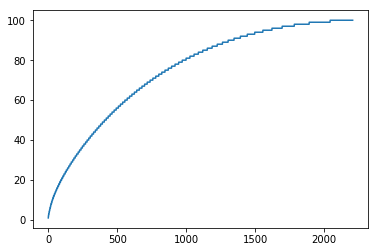

In [87]:
from sklearn.decomposition import PCA

pca = PCA().fit(data)

cum_variance = np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.plot(cum_variance)
plt.show()

In [90]:
n_components = np.argmax(cum_variance > 70) + 1
print("Selected n_components: {}".format(n_components))

transformed_data = PCA(n_components).fit_transform(data)
print("New transformed data shape: {}".format(transformed_data.shape))

Selected n_components: 1001
New transformed data shape: (4418, 1001)


70 clusters: Cost 3156.58; Silhouette avg 0.02543; Calinski-Harabasz Index:  7.86
80 clusters: Cost 3126.99; Silhouette avg 0.02157; Calinski-Harabasz Index:  7.37


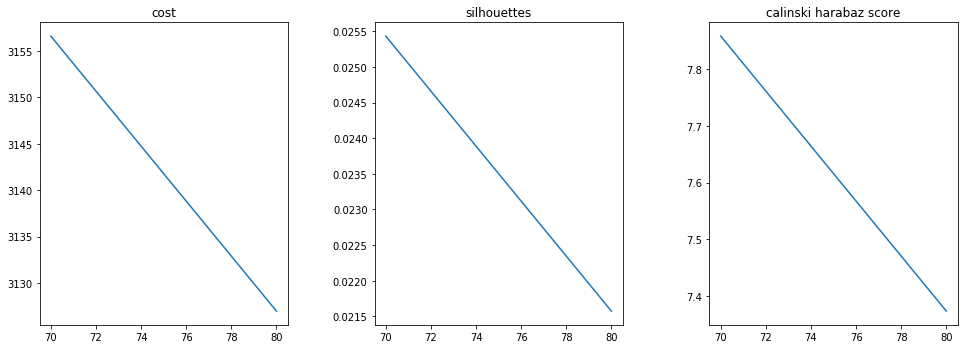

In [93]:
# Run again in transformed data
models, labels = runKmeansForMultipleCentroids(transformed_data)

In [94]:
# Chosen number of centroids
chosen_i = 14 #TEMP ????? --- modelo precisa ser escolhido
chosen_i = 0 #TEMP
chosen_model = models[chosen_i]
chosen_model_labels = labels[chosen_i]
print('Chosen # of centroids: {}'.format(chosen_model.n_clusters))
print('Cost:                    %18.3f' % costs[chosen_i])
print('Silhouette avg:          %18.3f' % sil_avgs[chosen_i])
print('Calinski-Harabasz Index: %18.3f' % ch_scores[chosen_i])
analyze_centroids(chosen_model, chosen_model_labels, data)

Chosen # of centroids: 70
Cost:                             18297.541
Silhouette avg:                       0.022
Calinski-Harabasz Index:             26.047
Selected groups: [59  9 24 26 37]


<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**3305df13917d994dbde5d9c333838152922d9499**<br>Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53234 talk.religion.misc:83631 talk.origins:40915<br>Newsgroups: alt.atheism,talk.religion.misc,talk.origins<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!mcsun!news.funet.fi!hydra!klaava!cust_ts<br>From: cust_ts@klaava.Helsinki.FI (Tero Sand)<br>Subject: Is macroevolution science? (Was: Re: Rawlins debunks creationism)<br>Message-ID: &lt;1993Apr16.074911.19998@klaava.Helsinki.FI&gt;<br>Followup-To: talk.origins<br>Organization: University of Helsinki<br>References: &lt;1993Apr10.213547.17644@rambo.atlanta.dg.com&gt; &lt;2BC8B03B.29868@ics.uci.edu&gt; &lt;1993Apr15.223844.16453@rambo.atlanta.dg.com&gt;<br>Date: Fri, 16 Apr 1993 07:49:11 GMT<br>Lines: 29<br><br>Notice the followup-line.<br><br>In article &lt;1993Apr15.223844.16453@rambo.atlanta.dg.com&gt; wpr@atlanta.dg.com (Bill Rawlins) writes:<br>&gt;    We are talking about origins, not merely science.   Science cannot<br>&gt;    explain origins.<br><br>So you have claimed, but you have never explained why. In detail.<br><br>  For a person to exclude anything but science from<br>&gt;    the issue of origins is to say that there is no higher truth<br>&gt;    than science.  This is a false premise.  By the way, I enjoy science.<br>&gt;    It is truly a wonder observing God's creation.  Macroevolution is<br>&gt;    a mixture of 15 percent science and 85 percent religion [guaranteed<br>&gt;    within three percent error :) ]<br><br>Again, you have claimed this, but you have never explained. You never<br>did explain how deducing macroevolution from its observable consequenses<br>(effects) is different from deducing Earth's roundness, its position in<br>the solar system, the existence of atoms and its components etc., from<br>observable effects.<br>Please do so or shut up on this subject.<br><br>	Tero Sand<br><br>-- <br>	EMail: cust_ts@cc.helsinki.fi   or   custts@cc.helsinki.fi<br>   "I feel most ministers who claim they've heard God's voice are eating<br>too much pizza before they go to bed at night, and it's really an <br>intestinal disorder, not a revelation." - Reverend Jerry Falwell<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**3305df13917d994dbde5d9c333838152922d9499**<br>Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53234 talk.religion.misc:83631 talk.origins:40915<br>Newsgroups: alt.atheism,talk.religion.misc,talk.origins<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!mcsun!news.funet.fi!hydra!klaava!cust_ts<br>From: cust_ts@klaava.Helsinki.FI (Tero Sand)<br>Subject: Is macroevolution science? (Was: Re: Rawlins debunks creationism)<br>Message-ID: &lt;1993Apr16.074911.19998@klaava.Helsinki.FI&gt;<br>Followup-To: talk.origins<br>Organization: University of Helsinki<br>References: &lt;1993Apr10.213547.17644@rambo.atlanta.dg.com&gt; &lt;2BC8B03B.29868@ics.uci.edu&gt; &lt;1993Apr15.223844.16453@rambo.atlanta.dg.com&gt;<br>Date: Fri, 16 Apr 1993 07:49:11 GMT<br>Lines: 29<br><br>Notice the followup-line.<br><br>In article &lt;1993Apr15.223844.16453@rambo.atlanta.dg.com&gt; wpr@atlanta.dg.com (Bill Rawlins) writes:<br>&gt;    We are talking about origins, not merely science.   Science cannot<br>&gt;    explain origins.<br><br>So you have claimed, but you have never explained why. In detail.<br><br>  For a person to exclude anything but science from<br>&gt;    the issue of origins is to say that there is no higher truth<br>&gt;    than science.  This is a false premise.  By the way, I enjoy science.<br>&gt;    It is truly a wonder observing God's creation.  Macroevolution is<br>&gt;    a mixture of 15 percent science and 85 percent religion [guaranteed<br>&gt;    within three percent error :) ]<br><br>Again, you have claimed this, but you have never explained. You never<br>did explain how deducing macroevolution from its observable consequenses<br>(effects) is different from deducing Earth's roundness, its position in<br>the solar system, the existence of atoms and its components etc., from<br>observable effects.<br>Please do so or shut up on this subject.<br><br>	Tero Sand<br><br>-- <br>	EMail: cust_ts@cc.helsinki.fi   or   custts@cc.helsinki.fi<br>   "I feel most ministers who claim they've heard God's voice are eating<br>too much pizza before they go to bed at night, and it's really an <br>intestinal disorder, not a revelation." - Reverend Jerry Falwell<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**4fbb651f3bf2695924b3ecd24f2f867f620d680e**<br>Xref: cantaloupe.srv.cs.cmu.edu misc.invest:41002 talk.politics.misc:178904<br>Newsgroups: misc.invest,talk.politics.misc<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!uwm.edu!linac!att!att!ulysses!lznj!lznj2!ncrhub2!ncratl!mwilson<br>From: mwilson@ncratl.AtlantaGA.NCR.COM (Mark Wilson)<br>Subject: Re: Bill Targets Pension Funds for " Liberation "<br>Message-ID: &lt;C5qqKE.97J@ncratl.AtlantaGA.NCR.COM&gt;<br>Organization: NCR Engineering and Manufacturing Atlanta -- Atlanta, GA<br>References: &lt;C5L8tq.qp@apollo.hp.com&gt; &lt;4916@master.CNA.TEK.COM&gt;<br>Date: Mon, 19 Apr 1993 17:14:37 GMT<br>Lines: 19<br><br>In &lt;4916@master.CNA.TEK.COM&gt; mikeq@freddy.CNA.TEK.COM (Mike Quigley) writes:<br><br>|&gt;&gt;|&gt;       Excerpts from "Insight" magazine, March 15, 1993<br><br><br>|                       Paranoia part deleted.<br><br>|  Isn't Insight magazine published by the Mooneys?<br><br>I don't remember the article that you removed so I can't comment on it.<br>What I can comment on though is your response.<br><br>Do you really believe that what you wrote is sufficient to refute the article?<br>Do have any facts in addition to your opinion?<br>-- <br>Mob rule isn't any prettier merely because the mob calls itself a government<br>It ain't charity if you are using someone else's money.<br>Wilson's theory of relativity: If you go back far enough, we're all related.<br>Mark.Wilson@AtlantaGA.NCR.com<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**a62ae471f7fad58c3ff97725fea3fd8be00c1e8c**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.religion.misc:84090 talk.politics.guns:54851 soc.culture.jewish:63498<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!noc.near.net!transfer.stratus.com!sw.stratus.com!cdt<br>From: cdt@sw.stratus.com (C. D. Tavares)<br>Newsgroups: talk.religion.misc,talk.politics.guns,soc.culture.jewish<br>Subject: Re: Who's next?  Mormons and Jews?<br>Followup-To: talk.politics.guns<br>Date: 21 Apr 1993 20:54:59 GMT<br>Organization: Stratus Computer, Inc.<br>Lines: 15<br>Distribution: world<br>Message-ID: &lt;1r4cb3408@transfer.stratus.com&gt;<br>References: &lt;1qvfik6rf@usenet.INS.CWRU.Edu&gt; &lt;C5rLnE.4pC@murdoch.acc.Virginia.EDU&gt;,&lt;1r1i414t@transfer.stratus.com&gt; &lt;1993Apr21.045548.17418@news.cs.brandeis.edu&gt;<br>NNTP-Posting-Host: rocket.sw.stratus.com<br><br>In article &lt;1993Apr21.045548.17418@news.cs.brandeis.edu&gt;, st922957@pip.cc.brandeis.edu (Arnold Schwarzenweisengreenbluenbraunenburger) writes:<br><br>&gt; Y'know, when the right to bear arms was "invented", all we had to worry<br>&gt; about was the shotgun and pistol. Now, we have to worry about drive-bys<br>&gt; with Uzis sparaying the entire neighborhood with bullets.<br><br>'Scuse me, I'm over here.  The large, rotund thing you're addressing is <br>a replica of Thomas Jefferson's private cannon.<br><br>Followups to t.p.g.<br>-- <br><br>cdt@rocket.sw.stratus.com   --If you believe that I speak for my company,<br>OR cdt@vos.stratus.com        write today for my special Investors' Packet...<br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**a62ae471f7fad58c3ff97725fea3fd8be00c1e8c**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.religion.misc:84090 talk.politics.guns:54851 soc.culture.jewish:63498<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!noc.near.net!transfer.stratus.com!sw.stratus.com!cdt<br>From: cdt@sw.stratus.com (C. D. Tavares)<br>Newsgroups: talk.religion.misc,talk.politics.guns,soc.culture.jewish<br>Subject: Re: Who's next?  Mormons and Jews?<br>Followup-To: talk.politics.guns<br>Date: 21 Apr 1993 20:54:59 GMT<br>Organization: Stratus Computer, Inc.<br>Lines: 15<br>Distribution: world<br>Message-ID: &lt;1r4cb3408@transfer.stratus.com&gt;<br>References: &lt;1qvfik6rf@usenet.INS.CWRU.Edu&gt; &lt;C5rLnE.4pC@murdoch.acc.Virginia.EDU&gt;,&lt;1r1i414t@transfer.stratus.com&gt; &lt;1993Apr21.045548.17418@news.cs.brandeis.edu&gt;<br>NNTP-Posting-Host: rocket.sw.stratus.com<br><br>In article &lt;1993Apr21.045548.17418@news.cs.brandeis.edu&gt;, st922957@pip.cc.brandeis.edu (Arnold Schwarzenweisengreenbluenbraunenburger) writes:<br><br>&gt; Y'know, when the right to bear arms was "invented", all we had to worry<br>&gt; about was the shotgun and pistol. Now, we have to worry about drive-bys<br>&gt; with Uzis sparaying the entire neighborhood with bullets.<br><br>'Scuse me, I'm over here.  The large, rotund thing you're addressing is <br>a replica of Thomas Jefferson's private cannon.<br><br>Followups to t.p.g.<br>-- <br><br>cdt@rocket.sw.stratus.com   --If you believe that I speak for my company,<br>OR cdt@vos.stratus.com        write today for my special Investors' Packet...<br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**2f5105cc057ed98e1b3fb17630bca3b1c4db97d0**<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!noc.near.net!transfer.stratus.com!sw.stratus.com!cdt<br>From: cdt@sw.stratus.com (C. D. Tavares)<br>Newsgroups: talk.politics.guns<br>Subject: A Scoop of Waco Road, Please<br>Date: 15 Apr 1993 14:26:31 GMT<br>Organization: Stratus Computer, Inc.<br>Lines: 13<br>Distribution: world<br>Message-ID: &lt;1qjran9sh@transfer.stratus.com&gt;<br>References: &lt;S539.2adf@looking.on.ca&gt;<br>NNTP-Posting-Host: rocket.sw.stratus.com<br>Keywords: topical, smirk<br><br>Your "lite" posting for the day, from rec.humor.funny:<br><br>In article &lt;S539.2adf@looking.on.ca&gt;, bellas@tti.com (Pete Bellas) writes:<br>&gt; <br>&gt; There is a new Ice Cream Flavor inspired by the incident at Waco.<br>&gt; <br>&gt; It's called Mount Caramel, it's full of nuts but you can't get it out<br>&gt; of the carton.<br>-- <br><br>cdt@rocket.sw.stratus.com   --If you believe that I speak for my company,<br>OR cdt@vos.stratus.com        write today for my special Investors' Packet...<br><br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**f02245b8169d44e10711db89625f4aaf4d706952**<br>Newsgroups: sci.crypt<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!zaphod.mps.ohio-state.edu!usc!sol.ctr.columbia.edu!ira.uka.de!math.fu-berlin.de!news.netmbx.de!Germany.EU.net!mcsun!uknet!pipex!ibmpcug!exnet!dcs.ed.ac.uk!pdc<br>From: pdc@dcs.ed.ac.uk (Paul Crowley)<br>Subject: Re: Secret algorithm [Re: Clipper Chip and crypto key-escrow]<br>Message-ID: &lt;C5s6I7.n0M@dcs.ed.ac.uk&gt;<br>Sender: cnews@dcs.ed.ac.uk (UseNet News Admin)<br>Reply-To: pdc@dcs.ed.ac.uk (Paul Crowley)<br>Organization: Edinburgh University<br>References: &lt;jhesseC5LuMC.2Ex@netcom.com&gt; &lt;1qnupdjpm@news.intercon.com&gt; &lt;PMETZGER.93Apr18141006@snark.shearson.com&gt; &lt;8AOHOnj024n@sktb.demon.co.uk&gt;<br>Date: Tue, 20 Apr 1993 11:56:30 GMT<br>Lines: 11<br><br>Quoting pla@sktb.demon.co.uk in article &lt;8AOHOnj024n@sktb.demon.co.uk&gt;:<br>&gt;You have every reason to be scared shitless.  Take a look at the records<br>&gt;of McCarthy, Hoover (J. Edgar, not the cleaner - though they both excelled at<br>&gt;sucking) and Nixon.<br><br>History does not record whether J. Edgar Hoover was any good at sucking.<br>As for the cleaners, I'll stick with my 850W Electrolux and damn the<br>carpet.<br>  __                                  _____<br>\/ o\ Paul Crowley   pdc@dcs.ed.ac.uk \\ //<br>/\__/ Trust me. I know what I'm doing. \X/  Fold a fish for Jesus!<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**24e6a6a9e4970e83790a356f4d5bad1e2e1fec0f**<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!rutgers!gatech!howland.reston.ans.net!ira.uka.de!news.dfn.de!Germany.EU.net!mcsun!uknet!warwick!qmw-dcs!qmw!demon!bart.demon.co.uk!mark<br>From: mark@bart.demon.co.uk (Mark Starzewski)<br>Newsgroups: sci.crypt<br>Subject: Re: Clipper: Two additional possible problems<br>Message-ID: &lt;736353277snz@bart.demon.co.uk&gt;<br>Date: 2 May 93 14:34:37 GMT<br>References: &lt;erwin.736304526@trwacs&gt;<br>Sender: usenet@demon.co.uk<br>Reply-To: mark@bart.demon.co.uk<br>Organization: DIS(organised)<br>Lines: 16<br>X-Mailer: Simple NEWS 1.90 (ka9q DIS 1.19)<br><br>In article &lt;erwin.736304526@trwacs&gt; erwin@trwacs.fp.trw.com writes:<br><br>&gt;Anyone interested in adopting British Telecom's quantum encryption scheme?<br>&gt;They've demonstrated it over a 10 km link. It automatically detects<br>&gt;wiretapping.<br>&gt;<br>If the BT phone system is anything to go by...me thinks this should be<br>approached with great caution.<br><br>Mark<br>--<br><br>..without warranty,                           Internet: mark@bart.demon.co.uk<br>   implied merchantability                          CIS: 100114,2415<br>   or fitness for a particular purpose...Yo Dude!<br> Click,Click...brrr...<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**6eed8602ccb5e06e22e4d0fa17221b16051bfdad**<br>Newsgroups: rec.motorcycles<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!pipex!demon!news<br>From: sdun@isma.demon.co.uk (Stephen Dunne)<br>Subject: Re: GGRRRrrr!! Cages double-parking motorc<br>Message-ID: &lt;C5L6w1.n04@demon.co.uk&gt;<br>News-Software: IBM OS/2 PM RN (NR/2) v0.17h by O. Vishnepolsky and R. Rogers<br>Lines: 22<br>Sender: news@demon.co.uk<br>Nntp-Posting-Host: isma.demon.co.uk<br>Reply-To: sdun@isma.demon.co.uk (Stephen Dunne)<br>Organization: Demon Internet Services.<br>References: &lt;34211@castle.ed.ac.uk&gt; &lt;1qjmf6d0i@sixgun.East.Sun.COM&gt;<br>Date: Fri, 16 Apr 1993 17:21:37 GMT<br><br>In &lt;1qjmf6d0i@sixgun.East.Sun.COM&gt; egreen@east.sun.com (Ed Green - Pixel Cruncher) writes:<br>&gt;In article 34211@castle.ed.ac.uk, wbg@festival.ed.ac.uk (W Geake) writes:<br>&gt;An apartment complex where I used to live tried this, only they put the<br>&gt;thing over the driver's window, "so they couldn't miss it."  A friend<br>&gt;damned near wrecked on the way home one night, her vision blocked by<br>&gt;the sticker.  I suggested to the manager the ENORMOUS liability they<br><br>&gt;Be careful about putting stickers on cages' windows.<br><br>Hmmm.. The LDDC security guards over here in Docklands only place parking <br>stickers on the drivers SIDE windows.. But on reflection that could still <br>cause an accident.. Suppose it's because people aren't as litigious over <br>here as in the states :-)<br><br>Stephen<br>--<br>+--------------------------------------------------------------------------+<br>|Stephen Dunne                         MAG DoD#766 sdun@isma.demon.co.uk   |<br>|International Securities Market Association       I speak for me,thats all|<br>|Voice (+44) 71-538-5656    Fax (+44) 71-538-4902  PGP public key available|<br>|We are not affiliated to any other Demon.Co.Uk site.                      |<br>+--------------------------------------------------------------------------+<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**4077a679d842579ad8b4cf6191928b360ccf3f65**<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!gatech!enterpoop.mit.edu!INTERNET!news-mail-gateway<br>From: min@stella.skku.ac.KR (Hyoung Bok Min)<br>Newsgroups: comp.windows.x<br>Subject: subscribe<br>Date: 23 Apr 1993 11:50:33 -0400<br>Organization: The Internet<br>Lines: 3<br>Sender: news@athena.mit.edu<br>Message-ID: &lt;9304230054.AA00434@stella.skku.ac.kr&gt;<br>To: expert@expo.lcs.mit.edu<br><br><br>subscribe min@stella.skku.ac.kr<br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**e9e01d61e71fd7e7999333a9d2a90fcaaf92947e**<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!pitt.edu!uunet!enterpoop.mit.edu!INTERNET!news-mail-gateway<br>From: rpicas@porto.INescn.PT (Rui Picas)<br>Newsgroups: comp.windows.x<br>Subject: subscrive<br>Message-ID: &lt;17rpicas@porto.inescn.pt&gt;<br>Date: 29 Apr 93 17:41:20 GMT<br>Sender: news@athena.mit.edu<br>Organization: The Internet<br>Lines: 3<br>NNTP-Posting-Host: enterpoop.mit.edu<br>To: xpert@export.lcs.mit.edu<br><br>please subscrive me.<br><br>rpicas@porto.inescn.pt<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**6572c2518f64af2dac4cf5a87206bda4d2a0e4f6**<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!darwin.sura.net!zaphod.mps.ohio-state.edu!sdd.hp.com!think.com!enterpoop.mit.edu!INTERNET!news-mail-gateway<br>From: EEI.EEIIHY@memo.ericsson.SE (353-1-2800455)<br>Newsgroups: comp.windows.x<br>Subject: help<br>Date: 26 Apr 1993 09:19:07 -0400<br>Organization: The Internet<br>Lines: 5<br>Sender: news@athena.mit.edu<br>Message-ID: &lt;qJOdnS2m63bNDeEM@mrp.ericsson.se&gt;<br>NNTP-Posting-Host: enterpoop.mit.edu<br>To: XPERT@EXPO.LCS.MIT.EDU<br><br>--- Received from EEI.EEIIHY  353-1-2800455         93-04-26 12.28<br>  -&gt; VAX.XPERT..EXPO.LCS.MIT.EDU..INET<br>  -: - - - - - - - - - - &gt; MAIL USER IN VAX AND INTERNET<br>help<br><br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**b2b433a7c864ee177ba2f672a5805f40125ade02**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.os.msdos.programmer:23274 alt.msdos.programmer:6789 sci.electronics:54006<br>Newsgroups: comp.os.msdos.programmer,alt.msdos.programmer,sci.electronics<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!bogus.sura.net!news-feed-1.peachnet.edu!umn.edu!csus.edu!sfsuvax1.sfsu.edu!kschang<br>From: kschang@sfsuvax1.sfsu.edu (Kuo-Sheng (Kasey) Chang)<br>Subject: Re: How to the disks copy protected.<br>Message-ID: &lt;1993Apr22.163605.24784@csus.edu&gt;<br>Sender: news@csus.edu<br>Organization: San Francisco State University<br>References: &lt;1993Apr20.230749.12821@reed.edu&gt; &lt;1993Apr21.085848.12704W@lumina.edb.tih.no&gt; &lt;1993Apr21.141137.863@imag.fr&gt;<br>Date: Thu, 22 Apr 1993 16:36:05 GMT<br>Lines: 75<br><br>In article &lt;1993Apr21.141137.863@imag.fr&gt; schaefer@imag.imag.fr (Arno Schaefer) writes:<br>&gt;In article &lt;1993Apr21.085848.12704W@lumina.edb.tih.no&gt;, ketil@edb.tih.no (Ketil Albertsen,TIH) writes:<br>&gt;|&gt; In article &lt;1993Apr20.230749.12821@reed.edu&gt;, mblock@reed.edu (Matt Block) writes:<br>&gt;&gt;&gt;	I guess what I am saying is that your question is difficult, if not<br>&gt;&gt;&gt;impossible, to answer. What exactly do you want to know?  Do you need a good<br>&gt;&gt;&gt;one for a project you are working on? How secure must it be?  Are you trying<br>&gt;&gt;&gt;to crack one that someone else has used?  I can probably make suggestions,<br>&gt;&gt;&gt;assuming the activity is strictly legal.  (In general, it is a BAD idea,<br>&gt;&gt;&gt;legally, to tamper with copy protection.  It can also lead to corruption of<br>&gt;&gt;&gt;files which you necessarily do not have back ups of (being as they are copy<br>&gt;&gt;&gt;protected,) which can be devestating.)  Do you have absolutely no ideas for<br>&gt;&gt;&gt;practical applications, and are merely curious?<br>&gt;&gt;&gt;	Please clear up those questions, and I'll try to help as much as I<br>&gt;&gt;&gt;can.<br>&gt;&gt; <br>&gt;&gt; May we interpret this as an offer to volunteer as editor for a<br>&gt;&gt; "Copy protection FAQ" ? I am quite sure that I am not alone welcoming such<br>&gt;&gt; an initiative! I will volunteer to ask some of the questions, if you will<br>&gt;&gt; provide the answers :-)<br>&gt;&gt; <br>&gt;Hey, now will you stop encouraging him? Copy protection only serves one pur-<br>&gt;pose: to keep the honest buyer from making (legal) backup copies. It will<br>&gt;definitely not stop any pirates. If you want to protect you soft, supply a<br>&gt;good documentation and support. This is IMHO the only way of effectively <br>&gt;protecting software.<br><br>There are several types of copy protection, and the point is to make sure the<br>user is using a legitimate copy.  The simplest and virtually fool-proof way is<br>for the program to somehow fixate itself to the machine it was installed on<br>(some sort of checksum, serial number, whatever) so a copy put on a different<br>machine (NOT installed from original disks) will not work.  <br><br>The program is definitely backupable, if restored to the same machine (depends<br>on the programmer...  don't use a disk drive characteristic!)  If the user <br>did an upgrade to the machine, he/she should reinstall all programs any way.<br>No document look-up, no disk wear-and-tear!<br><br>I did not say that the originals would allow only one install.  The user's <br>conscience should do that.<br><br>I know, I'll get flamed for this...  But with the increasing number of "casual"<br>users who either unknowingly or don't care about the software copyrights<br>(It's the truth.  I have "friends" who ask me for copies of my latest games<br>all the time, and when I refused, they went after somebody else.), casual<br>pirating is becoming more of a problem.  Some sort of copy protection will<br>discourage the casual copying.  I've seen what some of my "friends" dug up<br>somewhere...  Latest and the greatest games, all cracked, WITHIN days of actual<br>release!  You know how many bytes you need to change in X-wing to disable<br>the quiz?  TWO!  Yes, TWO!  (And don't ask me which ones they are.)  Determined<br>pirates are unstoppable, given enough time, but their results do not spread <br>that far, since pirate boards are not that well-known, and easily tracked once<br>found by authorities.  It is the "casual" pirates that the copy protection is<br>determined to discourage.<br><br>What I believe the companies should do is implement the above plus<br>a special patch once the user registers that loudly exclaims upon bootup<br>"REGISTERED TO XXXXX -- address, city, state zip" and disables the above.<br>Two benefits: 1) encourages registration, 2) cuts down on pirating and<br>makes it more traceable, because if the patch's registration message is<br>encrypted, it will be quite hard to change, and therefore provides a<br>stable trail of who allowed their copy out of their hands, and thus<br>violated their license agreement.<br><br>This way, the legitimate users who does not register will experience minimal <br>discomfort (who does major upgrades to their computer frequently?) as only<br>problem they have is they won't be able to restore to another computer.<br><br>The registered users would have proven they are legitmate users and therefore<br>gains full rights, and can restore to different machines.  On the other hand,<br>the software company now have a record of where THIS particular copy is <br>supposed to be.  If this user's copy was found to be somewhere it was not <br>supposed to be, we know who has broken their license agreement.  Of course,<br>a hacker can break that eventually, but that's not the point, is it?<br><br>--Kasey Chang<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**cf6fc2554ca21b66ec97ad3c5efc2b1e88bf61b6**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.os.msdos.programmer:23231 alt.msdos.programmer:6784 sci.electronics:53916<br>Newsgroups: comp.os.msdos.programmer,alt.msdos.programmer,sci.electronics<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!noc.near.net!uunet!pipex!uknet!warwick!zaphod.crihan.fr!univ-lyon1.fr!babbage!cosmos.imag.fr!cosmos!schaefer<br>From: schaefer@imag.imag.fr (Arno Schaefer)<br>Subject: Re: How to the disks copy protected.<br>Message-ID: &lt;1993Apr21.141137.863@imag.fr&gt;<br>Sender: news@imag.fr<br>Nntp-Posting-Host: silene<br>Organization: Institut Imag, Grenoble, France<br>References: &lt;sehari.735331566@marge.ecss.iastate.edu&gt; &lt;1993Apr20.230749.12821@reed.edu&gt; &lt;1993Apr21.085848.12704W@lumina.edb.tih.no&gt;<br>Date: Wed, 21 Apr 1993 14:11:37 GMT<br>Lines: 38<br><br>In article &lt;1993Apr21.085848.12704W@lumina.edb.tih.no&gt;, ketil@edb.tih.no (Ketil Albertsen,TIH) writes:<br>|&gt; In article &lt;1993Apr20.230749.12821@reed.edu&gt;, mblock@reed.edu (Matt Block) writes:<br>|&gt; <br>|&gt; &gt;	I guess what I am saying is that your question is difficult, if not<br>|&gt; &gt;impossible, to answer.  What exactly do you want to know?  Do you need a good<br>|&gt; &gt;one for a project you are working on?  How secure must it be?  Are you trying<br>|&gt; &gt;to crack one that someone else has used?  I can probably make suggestions,<br>|&gt; &gt;assuming the activity is strictly legal.  (In general, it is a BAD idea,<br>|&gt; &gt;legally, to tamper with copy protection.  It can also lead to corruption of<br>|&gt; &gt;files which you necessarily do not have back ups of (being as they are copy<br>|&gt; &gt;protected,) which can be devestating.)  Do you have absolutely no ideas for<br>|&gt; &gt;practical applications, and are merely curious?<br>|&gt; &gt;	Please clear up those questions, and I'll try to help as much as I<br>|&gt; &gt;can.<br>|&gt; <br>|&gt; May we interpret this as an offer to volunteer as editor for a<br>|&gt; "Copy protection FAQ" ? I am quite sure that I am not alone welcoming such<br>|&gt; an initiative! I will volunteer to ask some of the questions, if you will<br>|&gt; provide the answers :-)<br>|&gt; <br>|&gt; Ketil Albertsen<br><br>Hey, now will you stop encouraging him? Copy protection only serves one pur-<br>pose: to keep the honest buyer from making (legal) backup copies. It will<br>definitely not stop any pirates. If you want to protect you soft, supply a<br>good documentation and support. This is IMHO the only way of effectively pro-<br>tecting software.<br><br>Best Regards,<br><br>Arno<br><br>-- <br>--------------------------------------------------------------------------------<br>Arno Schaefer				ENSIMAG, 2e Annee<br>Email: schaefer@silene.imag.fr<br>Tel.: (33) 76 51 79 95			:-)<br>------- No, you're not paranoid - the world is really out to get you -----------<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**d69c6e7c9aff0128309797ce8bf8771d5c27ec99**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.os.msdos.programmer:23281 alt.msdos.programmer:6794 sci.electronics:54014<br>Newsgroups: comp.os.msdos.programmer,alt.msdos.programmer,sci.electronics<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!usc!cs.utexas.edu!uunet!mnemosyne.cs.du.edu!nyx!ggruscho<br>From: ggruscho@nyx.cs.du.edu (George Gruschow)<br>Subject: Re: How to the disks copy protected.<br>Message-ID: &lt;1993Apr22.180747.21756@mnemosyne.cs.du.edu&gt;<br>Sender: usenet@mnemosyne.cs.du.edu (netnews admin account)<br>Organization: University of Denver, Dept. of Math &amp; Comp. Sci.<br>References: &lt;sehari.735331566@marge.ecss.iastate.edu&gt; &lt;1993Apr20.230749.12821@reed.edu&gt; &lt;1993Apr21.085848.12704W@lumina.edb.tih.no&gt; &lt;1993Apr21.141137.863@imag.fr&gt;<br>Date: Thu, 22 Apr 93 18:07:47 GMT<br>Lines: 50<br><br>schaefer@imag.imag.fr (Arno Schaefer) writes:<br><br>&gt;In article &lt;1993Apr21.085848.12704W@lumina.edb.tih.no&gt;, ketil@edb.tih.no (Ketil Albertsen,TIH) writes:<br>&gt;|&gt; In article &lt;1993Apr20.230749.12821@reed.edu&gt;, mblock@reed.edu (Matt Block) writes:<br>&gt;|&gt; <br>&gt;|&gt; &gt;	I guess what I am saying is that your question is difficult, if not<br>&gt;|&gt; &gt;impossible, to answer.  What exactly do you want to know?  Do you need a good<br>&gt;|&gt; &gt;one for a project you are working on?  How secure must it be?  Are you trying<br>&gt;|&gt; &gt;to crack one that someone else has used?  I can probably make suggestions,<br>&gt;|&gt; &gt;assuming the activity is strictly legal.  (In general, it is a BAD idea,<br>&gt;|&gt; &gt;legally, to tamper with copy protection.  It can also lead to corruption of<br>&gt;|&gt; &gt;files which you necessarily do not have back ups of (being as they are copy<br>&gt;|&gt; &gt;protected,) which can be devestating.)  Do you have absolutely no ideas for<br>&gt;|&gt; &gt;practical applications, and are merely curious?<br>&gt;|&gt; &gt;	Please clear up those questions, and I'll try to help as much as I<br>&gt;|&gt; &gt;can.<br>&gt;|&gt; <br>&gt;|&gt; May we interpret this as an offer to volunteer as editor for a<br>&gt;|&gt; "Copy protection FAQ" ? I am quite sure that I am not alone welcoming such<br>&gt;|&gt; an initiative! I will volunteer to ask some of the questions, if you will<br>&gt;|&gt; provide the answers :-)<br>&gt;|&gt; <br>&gt;|&gt; Ketil Albertsen<br><br>&gt;Hey, now will you stop encouraging him? Copy protection only serves one pur-<br>&gt;pose: to keep the honest buyer from making (legal) backup copies. It will<br>&gt;definitely not stop any pirates. If you want to protect you soft, supply a<br>&gt;good documentation and support. This is IMHO the only way of effectively pro-<br>&gt;tecting software.<br><br>&gt;Best Regards,<br><br>&gt;Arno<br><br>&gt;-- <br>&gt;--------------------------------------------------------------------------------<br>&gt;Arno Schaefer				ENSIMAG, 2e Annee<br>&gt;Email: schaefer@silene.imag.fr<br>&gt;Tel.: (33) 76 51 79 95			:-)<br>&gt;------- No, you're not paranoid - the world is really out to get you -----------<br><br>Your wrong.  Never give up.  Update your program as much as possible, with a<br>very low price of upgrade to registered users (and PLEASE make sure you keep<br>a list of registered numbers!)...<br><br>--<br>-------------------------------------------------------------------------------<br>George Gruschow                                Death do you gronk.<br>ag625@yfn.ysu.edu                              ggruscho@nyx.cs.du.edu<br>-------------------------------------------------------------------------------<br></td></tr><tr></tr></table>